In [1]:
# Load libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
from scipy.stats import skew, kurtosis, boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_squared_log_error

#Regressors
from sklearn.linear_model import ARDRegression, BayesianRidge, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, LinearRegression, OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, PassiveAggressiveRegressor, PoissonRegressor, Ridge, RidgeCV, SGDRegressor, TheilSenRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import GammaRegressor, TweedieRegressor, PoissonRegressor, PassiveAggressiveRegressor, RANSACRegressor, HuberRegressor, QuantileRegressor

from statistics import mean,stdev
import scipy as sp

## Upload the training set

In [2]:
df1 = pd.read_csv('Train.csv')

df1

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


## Upload other csv files that might help

In [3]:
#Using Google API, we calculated the coordinates of the locations mentioned in our training and test sets.
#Using the coordinates of each location we found its ward. This was done using Google Earth Code Engine
#The code we wrote can be found at: https://code.earthengine.google.com/3569f5aba1e32a025024407aff663c93
locations = pd.read_csv('locations_lat_long.csv')

#For each ward we found its corresponding population density
#The source wikipedia table can be found here: https://en.wikipedia.org/wiki/List_of_wards_in_Bangalore
ward_density = pd.read_csv('ward_density.csv')
ward_parks = pd.read_csv('parks_per_ward.csv')

#We found the addresses of high schools, universities, hospitals and police stations in Bangalore
#We converted their addresses into lat-long coordinates using Google API
high_schools = pd.read_csv('high_schools_lat_long.csv')
universities = pd.read_csv('universities_lat_long.csv')
hospitals = pd.read_csv('hospitals_lat_long.csv')
police_stations = pd.read_csv('police_stations_lat_long.csv')
primary_schools = pd.read_csv('primary_schools_lat_long.csv')
parks = pd.read_csv('parks_lat_long.csv')

Combine these csv files to create one table containing important info

In [4]:
#Trim unecessary spaces in the beginning of the column
df1['location'] = df1['location'].str.lstrip()

df1

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


### Drop records with empty location
We will match each house with its ward. Therefore we want to get rid of blank location. They're not useful anyways.

In [5]:
df2 = df1.dropna(subset=['location'])

df2

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


#### Merge the dataframe with the wards of each location

In [6]:
# merge the two dataframes on the 'location' column
df3 = pd.merge(df2, locations, on='location', how='left')
df3[df3['ward'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward
92,Super built-up Area,Ready To Move,Mysore Highway,3 BHK,NaN,1450,2.0,2.0,70.0,NaN,NaN,NaN
809,Plot Area,18-Apr,4 Bedroom Farm House in Bagalur,4 Bedroom,NaN,10961,4.0,1.0,80.0,NaN,NaN,NaN
2448,Plot Area,18-Feb,ittamadu,3 Bedroom,NaN,600,2.0,1.0,110.0,NaN,NaN,NaN
2852,Built-up Area,Ready To Move,Mysore Highway,1 BHK,NaN,600,1.0,1.0,17.0,NaN,NaN,NaN
3125,Built-up Area,Ready To Move,Kanakapura Road,3 Bedroom,NaN,1950,3.0,2.0,130.0,NaN,NaN,NaN
3219,Plot Area,19-Dec,"Off Sarjapur road,",4 Bedroom,NaN,3000,4.0,3.0,342.0,NaN,NaN,NaN
3981,Plot Area,Ready To Move,Anand nagar,2 Bedroom,NaN,1200,2.0,0.0,70.0,NaN,NaN,NaN
5187,Plot Area,Ready To Move,t.c palya,6 Bedroom,NaN,1350,6.0,3.0,160.0,NaN,NaN,NaN
5848,Plot Area,Ready To Move,south,3 Bedroom,NaN,2400,2.0,0.0,480.0,NaN,NaN,NaN
6533,Super built-up Area,Ready To Move,Anand nagar,3 BHK,NaN,2010,3.0,3.0,125.0,NaN,NaN,NaN


#### Replace values that are similar with valid values

In [7]:
df2.loc[df2['location'] == 'RR Nagar','location'] = 'Rajarajeshwari Nagara'
df2.loc[df2['location'] == 'Kanakapura Road', 'location'] = 'Kanakapura'
df2.loc[df2['location'] == 'Kanakapura Main Road', 'location'] = 'Kanakapura'
df2.loc[df2['location'] == 'Mysore Highway', 'location'] = 'Mysore Road'

df3 = pd.merge(df2, locations, on='location', how='left')

df3[df3['ward'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward
809,Plot Area,18-Apr,4 Bedroom Farm House in Bagalur,4 Bedroom,NaN,10961,4.0,1.0,80.0,NaN,NaN,NaN
2448,Plot Area,18-Feb,ittamadu,3 Bedroom,NaN,600,2.0,1.0,110.0,NaN,NaN,NaN
3219,Plot Area,19-Dec,"Off Sarjapur road,",4 Bedroom,NaN,3000,4.0,3.0,342.0,NaN,NaN,NaN
3981,Plot Area,Ready To Move,Anand nagar,2 Bedroom,NaN,1200,2.0,0.0,70.0,NaN,NaN,NaN
5187,Plot Area,Ready To Move,t.c palya,6 Bedroom,NaN,1350,6.0,3.0,160.0,NaN,NaN,NaN
5848,Plot Area,Ready To Move,south,3 Bedroom,NaN,2400,2.0,0.0,480.0,NaN,NaN,NaN
6533,Super built-up Area,Ready To Move,Anand nagar,3 BHK,NaN,2010,3.0,3.0,125.0,NaN,NaN,NaN
6551,Plot Area,Ready To Move,5 Bedroom Farm House in Lakshmipura,5 Bedroom,NaN,24Guntha,6.0,2.0,550.0,NaN,NaN,NaN
7339,Plot Area,Ready To Move,BEML Layout 5th Stage,4 Bedroom,NaN,1200,5.0,NaN,325.0,NaN,NaN,NaN
9102,Built-up Area,Ready To Move,south,4 BHK,NaN,3420,3.0,2.0,410.0,NaN,NaN,NaN


#### Drop records with empty ward

In [8]:
# replace empty strings with NaN values
df3['ward'] = df3['ward'].replace('', pd.NA)

# drop rows with NaN values in the 'ward' column
df3 = df3.dropna(subset=['ward'])
df3 = df3.reset_index(drop=True)

df3[df3['ward'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward


#### Merge the dataframe with Ward Density

In [9]:
df3b = pd.merge(df3, ward_density, on='ward', how='left')
df3b

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward,density
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,77.679381,Outside of town,27566
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,77.866742,Outside of town,27566
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,77.552059,Vasanthapura,10852
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,77.513787,Hemmigepura,1652
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,77.642221,Horamavu,5437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,77.749972,Hagadooru,4003
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,77.614948,Sagayarapuram,45792
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,77.520640,Rajarajeshwarinagar,5112
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,77.556773,Padmanabhanagar,24311


#### Merge the dataframe with the number of parks per ward

In [10]:
df3c = pd.merge(df3b, ward_parks, on='ward', how='left')
df3c

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward,density,parks_per_ward
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,77.679381,Outside of town,27566,NaN
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,77.866742,Outside of town,27566,NaN
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,77.552059,Vasanthapura,10852,4.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,77.513787,Hemmigepura,1652,3.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,77.642221,Horamavu,5437,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,77.749972,Hagadooru,4003,1.0
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,77.614948,Sagayarapuram,45792,1.0
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,77.520640,Rajarajeshwarinagar,5112,14.0
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,77.556773,Padmanabhanagar,24311,8.0


### Find nearest amenities (Schools, Hospitals, Parks, Police Stations, Universities)
#### Haversine distance is used to calculate the distance between 2 lat-long pairs. We assume the equatorial distance is 6367km

In [11]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

#### Method that finds the number of amenities under a threshold distance and the closest amenity
The commented for loop is replaced with a more complex algorithm that used numpy instead for faster calculations

In [12]:
def find_nearest_places(df_0, places, str1, str2, threshold):
    df_1 = df_0.copy()
    df_1 = df_1.merge(places, how='cross')
    km = haversine_np(df_1['long_x'],df_1['lat_x'],df_1['long_y'],df_1['lat_y'])
    
    #FOR LOOPS TOO SLOW
    #distances = []
    #for i in range(len(df_0.index)):
    #    for j in range(len(places.index)):
    #        distances.append({'HouseIndex': i, 
    #                          'PlaceIndex': j, 
    #                          'Distance': km[i*len(places.index)+j]})
    
    
    # convert distances to dataframe
    km1 = km.values
    km1 = km1.reshape(len(df_0.index), len(places.index))

    x1 =np.repeat(np.arange(km1.shape[0]), len(km1.flatten())/len(np.arange(km1.shape[0])))
    x2 =np.tile(np.arange(km1.shape[1]), int(len(km1.flatten())/len(np.arange(km1.shape[1]))))
    x3= km1.flatten()

    distances_df = pd.DataFrame(np.array([x1,x2,x3]).T, columns=['HouseIndex','PlaceIndex','Distance'])
    distances_df['HouseIndex'] = distances_df['HouseIndex'].astype(int)
    distances_df['PlaceIndex'] = distances_df['PlaceIndex'].astype(int)
    
    # calculate minimum distance for each house
    result_1 = distances_df.groupby('HouseIndex').agg({'Distance': 'min'})
    
    # rename columns for clarity
    result_1 = result_1.rename(columns={'Distance': str2})
    
    # filter distances to only include schools within 3km
    close_places = distances_df.loc[distances_df['Distance'] <= threshold]

    # calculate number of places for each house
    result_2 = close_places.groupby('HouseIndex').agg({'PlaceIndex': 'count'})
    
    # rename columns for clarity
    result_2 = result_2.rename(columns={'PlaceIndex': str1})

    # merge results with original house dataframe
    df_2 = pd.merge(df_0, result_1, how='left', left_index=True, right_index=True)
    df_3 = pd.merge(df_2, result_2, how='left', left_index=True, right_index=True)
    df_3[str1] = df_3[str1].fillna(0)
    df_3[str1] = df_3[str1].astype(int)

    # return final dataframe
    return df_3

#### Nearest High Schools

In [13]:
df4 = find_nearest_places(df3c, high_schools, "high_schools_3km", "nearest_high_school", 3)

df4

#df4[df4["high_schools_3km"].isna()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,77.679381,Outside of town,27566,NaN,0.842733,4
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,77.866742,Outside of town,27566,NaN,8.578895,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,77.552059,Vasanthapura,10852,4.0,0.000000,17
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,77.513787,Hemmigepura,1652,3.0,2.445457,1
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,77.642221,Horamavu,5437,1.0,1.549047,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,77.749972,Hagadooru,4003,1.0,0.714559,6
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,77.614948,Sagayarapuram,45792,1.0,1.464174,12
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,77.520640,Rajarajeshwarinagar,5112,14.0,0.840693,10
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,77.556773,Padmanabhanagar,24311,8.0,0.109952,22


#### Nearest Hospitals

In [14]:
df5 = find_nearest_places(df4, hospitals, "hospitals_5km", "nearest_hospital", 5)

df5

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,77.679381,Outside of town,27566,NaN,0.842733,4,0.702709,17
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,77.866742,Outside of town,27566,NaN,8.578895,0,13.856962,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,77.552059,Vasanthapura,10852,4.0,0.000000,17,1.034118,132
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,77.513787,Hemmigepura,1652,3.0,2.445457,1,3.403518,9
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,77.642221,Horamavu,5437,1.0,1.549047,4,0.537671,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,77.749972,Hagadooru,4003,1.0,0.714559,6,0.000000,39
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,77.614948,Sagayarapuram,45792,1.0,1.464174,12,0.328717,158
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,77.520640,Rajarajeshwarinagar,5112,14.0,0.840693,10,0.197452,50
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,77.556773,Padmanabhanagar,24311,8.0,0.109952,22,0.148021,163


#### Nearest Universities

In [15]:
df6 = find_nearest_places(df5, universities, "universities_5km", "nearest_university", 5)

df6

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,77.679381,Outside of town,27566,NaN,0.842733,4,0.702709,17,5.142606,0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,77.866742,Outside of town,27566,NaN,8.578895,0,13.856962,0,11.292030,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,77.552059,Vasanthapura,10852,4.0,0.000000,17,1.034118,132,3.612492,2
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,77.513787,Hemmigepura,1652,3.0,2.445457,1,3.403518,9,7.188967,0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,77.642221,Horamavu,5437,1.0,1.549047,4,0.537671,48,7.077577,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,77.749972,Hagadooru,4003,1.0,0.714559,6,0.000000,39,12.268435,0
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,77.614948,Sagayarapuram,45792,1.0,1.464174,12,0.328717,158,3.789473,5
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,77.520640,Rajarajeshwarinagar,5112,14.0,0.840693,10,0.197452,50,2.811538,2
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,77.556773,Padmanabhanagar,24311,8.0,0.109952,22,0.148021,163,3.161392,2


#### Nearest Police Stations

In [16]:
df7 = find_nearest_places(df6, police_stations, "police_stations_3km", "nearest_police_station", 3)

df7

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,...,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,...,27566,NaN,0.842733,4,0.702709,17,5.142606,0,2.160838,1
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,...,27566,NaN,8.578895,0,13.856962,0,11.292030,0,6.912706,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,...,10852,4.0,0.000000,17,1.034118,132,3.612492,2,1.044202,5
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,...,1652,3.0,2.445457,1,3.403518,9,7.188967,0,2.283267,1
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,...,5437,1.0,1.549047,4,0.537671,48,7.077577,0,0.447469,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,...,4003,1.0,0.714559,6,0.000000,39,12.268435,0,0.629064,2
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,...,45792,1.0,1.464174,12,0.328717,158,3.789473,5,0.906158,6
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,...,5112,14.0,0.840693,10,0.197452,50,2.811538,2,0.222472,3
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,...,24311,8.0,0.109952,22,0.148021,163,3.161392,2,1.169012,6


#### Nearest Parks

In [17]:
df7b = find_nearest_places(df7, parks, "parks_3km", "nearest_park", 3)

df7b

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,...,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,...,0.842733,4,0.702709,17,5.142606,0,2.160838,1,1.165816,3
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,...,8.578895,0,13.856962,0,11.292030,0,6.912706,0,7.916471,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,...,0.000000,17,1.034118,132,3.612492,2,1.044202,5,0.000000,51
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,...,2.445457,1,3.403518,9,7.188967,0,2.283267,1,1.466480,1
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,...,1.549047,4,0.537671,48,7.077577,0,0.447469,2,1.939158,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,...,0.714559,6,0.000000,39,12.268435,0,0.629064,2,0.293975,2
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,...,1.464174,12,0.328717,158,3.789473,5,0.906158,6,0.000000,40
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,...,0.840693,10,0.197452,50,2.811538,2,0.222472,3,0.000000,22
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,...,0.109952,22,0.148021,163,3.161392,2,1.169012,6,0.161497,66


#### Nearest Primary Schools

In [18]:
df7c = find_nearest_places(df7b, primary_schools, "primary_schools_2km", "nearest_primary_school", 2)

df7c

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,...,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,...,0.702709,17,5.142606,0,2.160838,1,1.165816,3,0.804007,12
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,...,13.856962,0,11.292030,0,6.912706,0,7.916471,0,2.268728,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,...,1.034118,132,3.612492,2,1.044202,5,0.000000,51,0.000000,27
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,...,3.403518,9,7.188967,0,2.283267,1,1.466480,1,0.189312,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,...,0.537671,48,7.077577,0,0.447469,2,1.939158,16,0.889883,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13300,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,12.969820,...,0.000000,39,12.268435,0,0.629064,2,0.293975,2,0.069651,15
13301,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00,13.006322,...,0.328717,158,3.789473,5,0.906158,6,0.000000,40,0.363873,41
13302,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,12.914860,...,0.197452,50,2.811538,2,0.222472,3,0.000000,22,0.000000,8
13303,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,12.915569,...,0.148021,163,3.161392,2,1.169012,6,0.161497,66,0.440358,29


#### Save the current status of the dataframe after the feature expansion

In [19]:
df7c.to_csv('new_train_set2.csv')

In [20]:
df8 = df7c.reset_index(drop=True)

df8.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,lat,...,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.844149,...,0.702709,17,5.142606,0,2.160838,1,1.165816,3,0.804007,12
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.896745,...,13.856962,0,11.292030,0,6.912706,0,7.916471,0,2.268728,0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.906982,...,1.034118,132,3.612492,2,1.044202,5,0.000000,51,0.000000,27
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,12.874358,...,3.403518,9,7.188967,0,2.283267,1,1.466480,1,0.189312,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.055193,...,0.537671,48,7.077577,0,0.447469,2,1.939158,16,0.889883,8


### We will now start evaluating our data and cleaning the dataset

In [21]:
df8.shape

(13305, 26)

In [22]:
df8.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price', 'lat', 'long', 'ward',
       'density', 'parks_per_ward', 'nearest_high_school', 'high_schools_3km',
       'nearest_hospital', 'hospitals_5km', 'nearest_university',
       'universities_5km', 'nearest_police_station', 'police_stations_3km',
       'nearest_park', 'parks_3km', 'nearest_primary_school',
       'primary_schools_2km'],
      dtype='object')

In [23]:
df8.dtypes

area_type                  object
availability               object
location                   object
size                       object
society                    object
total_sqft                 object
bath                      float64
balcony                   float64
price                     float64
lat                       float64
long                      float64
ward                       object
density                     int64
parks_per_ward            float64
nearest_high_school       float64
high_schools_3km            int32
nearest_hospital          float64
hospitals_5km               int32
nearest_university        float64
universities_5km            int32
nearest_police_station    float64
police_stations_3km         int32
nearest_park              float64
parks_3km                   int32
nearest_primary_school    float64
primary_schools_2km         int32
dtype: object

#### Drop unecessary columns

In [24]:
df8.isnull().sum()

area_type                    0
availability                 0
location                     0
size                        16
society                   5488
total_sqft                   0
bath                        73
balcony                    608
price                        0
lat                          0
long                         0
ward                         0
density                      0
parks_per_ward            2501
nearest_high_school          0
high_schools_3km             0
nearest_hospital             0
hospitals_5km                0
nearest_university           0
universities_5km             0
nearest_police_station       0
police_stations_3km          0
nearest_park                 0
parks_3km                    0
nearest_primary_school       0
primary_schools_2km          0
dtype: int64

In [25]:
df8.area_type.value_counts()

Super built-up  Area    8787
Built-up  Area          2415
Plot  Area              2016
Carpet  Area              87
Name: area_type, dtype: int64

<AxesSubplot:>

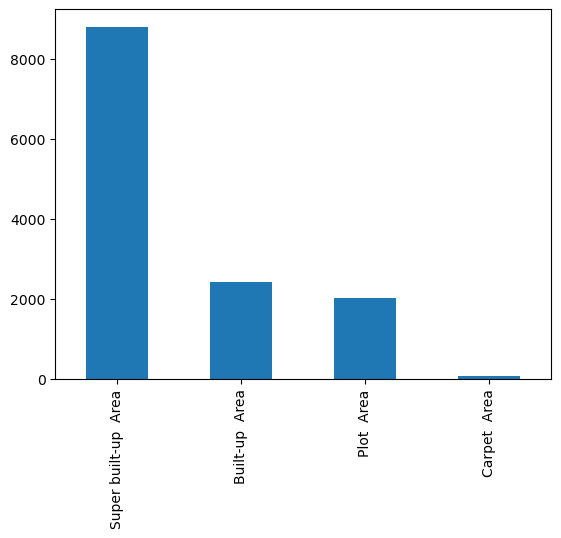

In [26]:
df8.area_type.value_counts().plot(kind='bar')

#### Replacing availability with the 'ready_to_move' column

In [27]:
df9 = df8.copy()
df9['ready_to_move'] = df9['availability'].apply(lambda x: 1 if x == 'Ready To Move' else 0)

In [28]:
df10 = df9.copy()
df10.drop(columns=['availability','area_type', 'society', 'balcony'],inplace = True)
df10.dtypes

location                   object
size                       object
total_sqft                 object
bath                      float64
price                     float64
lat                       float64
long                      float64
ward                       object
density                     int64
parks_per_ward            float64
nearest_high_school       float64
high_schools_3km            int32
nearest_hospital          float64
hospitals_5km               int32
nearest_university        float64
universities_5km            int32
nearest_police_station    float64
police_stations_3km         int32
nearest_park              float64
parks_3km                   int32
nearest_primary_school    float64
primary_schools_2km         int32
ready_to_move               int64
dtype: object

#### Convert object type columns to numeric

In [29]:
df11 = df10.copy()
# extract the number of bedrooms from the 'size' column
df11['bedrooms'] = df11['size'].str.split().str[0]

# replace empty strings with NaN values
df11['bedrooms'] = df11['bedrooms'].replace('', pd.NA)

# drop rows with NaN values in the 'bedrooms' column
df11 = df11.dropna(subset=['bedrooms'])
df11 = df11.reset_index(drop=True)
df11['bedrooms'] = df11['bedrooms'].astype('int')

In [30]:
df12 = df11.copy()
df12['bath'] = df12['bath'].fillna(df12['bath'].notnull().mean())
df12['bath'] = df12['bath'].astype('int')

In [31]:
df12['parks_per_ward'] = df12['parks_per_ward'].fillna(df12['parks_per_ward'].mean())

In [32]:
df13 = df12.copy()
df13['studio'] = df13['size'].apply(lambda x: 0 if x.split()[1] == 'BHK' else 1)
df13.drop(columns=['size'],inplace = True)

In [33]:
df13.isnull().sum()

location                  0
total_sqft                0
bath                      0
price                     0
lat                       0
long                      0
ward                      0
density                   0
parks_per_ward            0
nearest_high_school       0
high_schools_3km          0
nearest_hospital          0
hospitals_5km             0
nearest_university        0
universities_5km          0
nearest_police_station    0
police_stations_3km       0
nearest_park              0
parks_3km                 0
nearest_primary_school    0
primary_schools_2km       0
ready_to_move             0
bedrooms                  0
studio                    0
dtype: int64

In [34]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [35]:
df13[~df13["total_sqft"].apply(is_float)].head(10)

,location,total_sqft,bath,price,lat,long,ward,density,parks_per_ward,nearest_high_school,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio
30,Yelahanka,2100 - 2850,4,186.000,13.115466,77.606998,Kempegowda Ward,3182,0.000000,0.000000,...,0,0.000000,1,0.000000,14,0.000000,99,0,4,0
56,Devanahalli,3010 - 3410,0,192.000,13.150773,77.708811,Outside of town,27566,4.257527,4.934797,...,0,5.349833,0,9.734515,0,2.896529,0,0,4,1
81,Hennur Road,2957 - 3450,0,224.500,13.013906,77.626650,HBR Layout,12717,5.000000,1.220832,...,1,1.773094,5,0.108980,43,0.000000,37,0,4,1
122,Hebbal,3067 - 8156,4,477.000,13.035356,77.598787,Hebbala,26455,5.000000,0.656391,...,1,1.049216,6,0.339309,17,0.210874,37,0,4,0
137,8th Phase JP Nagar,1042 - 1105,2,54.005,12.874108,77.579173,Gottigere,7049,2.000000,0.614314,...,0,1.764432,2,0.485631,18,0.000000,11,0,2,0
165,Sarjapur,1145 - 1340,2,43.490,12.857558,77.786406,Outside of town,27566,4.257527,0.000000,...,1,9.245514,0,11.063105,0,0.000000,24,0,2,0
188,KR Puram,1015 - 1540,2,56.800,13.016999,77.704433,Krishnarajapuram,7308,3.000000,0.745847,...,0,0.000000,3,0.688187,4,0.000000,12,1,2,0
224,Devanahalli,1520 - 1740,0,74.820,13.150773,77.708811,Outside of town,27566,4.257527,4.934797,...,0,5.349833,0,9.734515,0,2.896529,0,0,3,0
410,Kengeri,34.46Sq. Meter,1,18.500,12.899668,77.482684,Hemmigepura,1652,3.000000,1.143172,...,0,1.150818,2,0.000000,11,0.000000,17,1,1,0
549,Hennur Road,1195 - 1440,2,63.770,13.013906,77.626650,HBR Layout,12717,5.000000,1.220832,...,1,1.773094,5,0.108980,43,0.000000,37,0,2,0


In [36]:
# conversion factors for non-numeric units
conversion_dict = {"Sq Meter": 10.7639, "Sq Yards": 9, "Acres": 43560, "Cents": 435.6, "Grounds": 2400, "Guntha": 1089, "Perch": 272.25}

def convert_to_sqft(value):
    # check if value contains non-numeric unit
    match = re.search(r'(\d+(?:\.\d+)?)\s*([a-zA-Z]+\.*\s*[a-zA-Z]*)', value)
    if match:
        numeric_value = float(match.group(1))
        unit = match.group(2).strip().replace(".", "")
        #print(unit)
        # check if unit is in the conversion dictionary
        if unit in conversion_dict:
            # convert to square feet using conversion factor
            sqft_value = numeric_value * conversion_dict[unit]
            return int(sqft_value)
    # if value does not contain a non-numeric unit, check if it is a range
    elif '-' in value:
        # extract range values
        range_values = value.split('-')
        # calculate median value of range
        median_value = sum(map(float, range_values)) / len(range_values)
        return int(median_value)
    # if value is a single numeric value, convert to int
    else:
        if(value[-1]=='.'):
            value = value[:-1]
        numeric_value = float(re.sub('[^0-9\.]', '', value))
        return int(numeric_value)


In [37]:
df14 = df13.copy()
df14['total_sqft'] = df14['total_sqft'].apply(convert_to_sqft)
max_id = df14['total_sqft'].idxmax()

print('ID of maximum value:', max_id)
print(df14.loc[max_id])
print(df13.loc[max_id])

ID of maximum value: 1083
location                       Narasapura
total_sqft                        1306800
bath                                    2
price                                29.5
lat                             13.109186
long                            77.463026
ward                      Outside of town
density                             27566
parks_per_ward                   4.257527
nearest_high_school              3.167841
high_schools_3km                        0
nearest_hospital                 3.553192
hospitals_5km                           1
nearest_university              10.209925
universities_5km                        0
nearest_police_station           3.309776
police_stations_3km                     0
nearest_park                     6.628473
parks_3km                               0
nearest_primary_school           0.037024
primary_schools_2km                     4
ready_to_move                           0
bedrooms                                2
studio  

In [38]:
df14[~df14["total_sqft"].apply(is_float)].head(10)

,location,total_sqft,bath,price,lat,long,ward,density,parks_per_ward,nearest_high_school,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio


In [39]:
df14[df14["total_sqft"].isnull()]

,location,total_sqft,bath,price,lat,long,ward,density,parks_per_ward,nearest_high_school,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio


In [40]:
df14["total_sqft"]

0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13284    3453
13285    3600
13286    1141
13287    4689
13288     550
Name: total_sqft, Length: 13289, dtype: int64

In [41]:
df14.dtypes

location                   object
total_sqft                  int64
bath                        int32
price                     float64
lat                       float64
long                      float64
ward                       object
density                     int64
parks_per_ward            float64
nearest_high_school       float64
high_schools_3km            int32
nearest_hospital          float64
hospitals_5km               int32
nearest_university        float64
universities_5km            int32
nearest_police_station    float64
police_stations_3km         int32
nearest_park              float64
parks_3km                   int32
nearest_primary_school    float64
primary_schools_2km         int32
ready_to_move               int64
bedrooms                    int32
studio                      int64
dtype: object

#### We will deal with location and wards at a later stage

### Removing outliers

In [42]:
df15 = df14[~(df14.total_sqft/df14.bedrooms<200)]
df15.shape

(12947, 24)

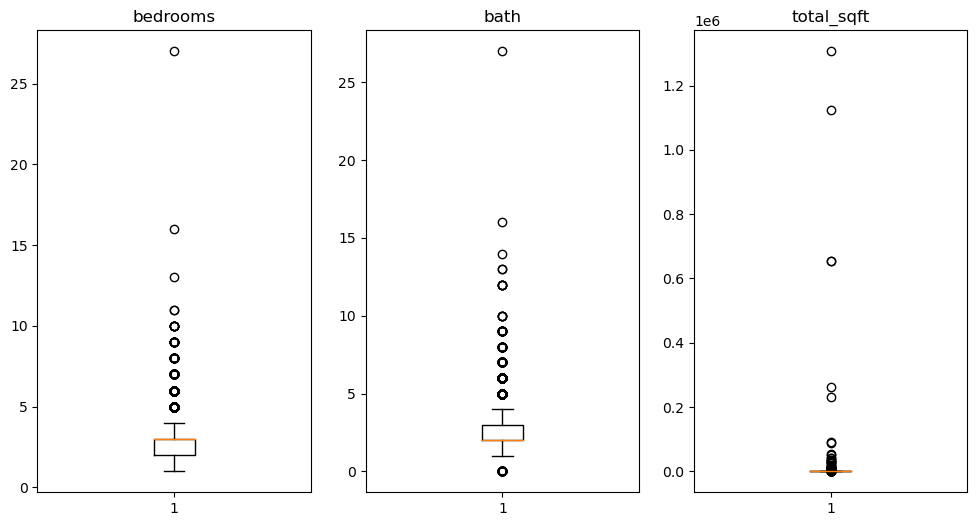

In [43]:
# select the three columns you want to plot
column1 = 'bedrooms'
column2 = 'bath'
column3 = 'total_sqft'

# create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# plot the boxplots of the three columns in each subplot
axs[0].boxplot(df15[column1])
axs[0].set_title(column1)
axs[1].boxplot(df15[column2])
axs[1].set_title(column2)
axs[2].boxplot(df15[column3])
axs[2].set_title(column3)

# display the plot
plt.show()

In [44]:
df16 = df15.copy()
df16 = df16.drop(df16[df16['bath']>6].index)
df16 = df16.drop(df16[df16['bedrooms']>7.0].index)
df16.shape

(12803, 24)

#### Creating a new columns named 'price_per_sqft' that is going to be used for outlier removal

In [45]:
df17=df16.copy()
df17["price_per_sqft"]=df17["price"]*1000000/df17["total_sqft"]
df17.head()

,location,total_sqft,bath,price,lat,long,ward,density,parks_per_ward,nearest_high_school,...,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio,price_per_sqft
0,Electronic City Phase II,1056,2,39.07,12.844149,77.679381,Outside of town,27566,4.257527,0.842733,...,2.160838,1,1.165816,3,0.804007,12,0,2,0,36998.106061
1,Chikka Tirupathi,2600,5,120.00,12.896745,77.866742,Outside of town,27566,4.257527,8.578895,...,6.912706,0,7.916471,0,2.268728,0,1,4,1,46153.846154
2,Uttarahalli,1440,2,62.00,12.906982,77.552059,Vasanthapura,10852,4.000000,0.000000,...,1.044202,5,0.000000,51,0.000000,27,1,3,0,43055.555556
3,Lingadheeranahalli,1521,3,95.00,12.874358,77.513787,Hemmigepura,1652,3.000000,2.445457,...,2.283267,1,1.466480,1,0.189312,3,1,3,0,62458.908613
4,Kothanur,1200,2,51.00,13.055193,77.642221,Horamavu,5437,1.000000,1.549047,...,0.447469,2,1.939158,16,0.889883,8,1,2,0,42500.000000


#### Checking for skewness

In [46]:
num_cols = df17.select_dtypes(include=['float64', 'int64'])

# calculate skewness and kurtosis for each column
skewness = num_cols.skew()
kurtosis = num_cols.kurtosis()

# display the resulting series
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 total_sqft                82.790070
price                      7.444456
lat                        0.415428
long                      -0.384092
density                    0.917789
parks_per_ward             2.883243
nearest_high_school       37.455883
nearest_hospital          23.776063
nearest_university         7.280501
nearest_police_station    19.249829
nearest_park               4.259534
nearest_primary_school    24.787675
ready_to_move             -1.422203
studio                     1.810233
price_per_sqft             8.169132
dtype: float64

Kurtosis:
 total_sqft                7557.668683
price                       94.207916
lat                          1.196206
long                        11.864653
density                      0.499519
parks_per_ward              10.616139
nearest_high_school       2188.614332
nearest_hospital          1196.463100
nearest_university         230.418386
nearest_police_station     900.748637
nearest_park                42.512957
near

#### Use of boxcox and logarithmic transformation to see which is better

In [47]:
col_to_transform = 'price_per_sqft'

# apply the Box-Cox transformation to the column
transformed_col, lambda_value = boxcox(df17[col_to_transform])

# add the transformed column to the DataFrame
df17['transformed_col'] = transformed_col

df17['transformed_col1'] = np.log(df17[col_to_transform])

In [48]:
num_cols = df17.select_dtypes(include=['float64', 'int64'])

# calculate skewness and kurtosis for each column
skewness = num_cols.skew()
kurtosis = num_cols.kurtosis()

# display the resulting series
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 total_sqft                82.790070
price                      7.444456
lat                        0.415428
long                      -0.384092
density                    0.917789
parks_per_ward             2.883243
nearest_high_school       37.455883
nearest_hospital          23.776063
nearest_university         7.280501
nearest_police_station    19.249829
nearest_park               4.259534
nearest_primary_school    24.787675
ready_to_move             -1.422203
studio                     1.810233
price_per_sqft             8.169132
transformed_col            0.005762
transformed_col1          -0.025119
dtype: float64

Kurtosis:
 total_sqft                7557.668683
price                       94.207916
lat                          1.196206
long                        11.864653
density                      0.499519
parks_per_ward              10.616139
nearest_high_school       2188.614332
nearest_hospital          1196.463100
nearest_university         230.418386
nearest_

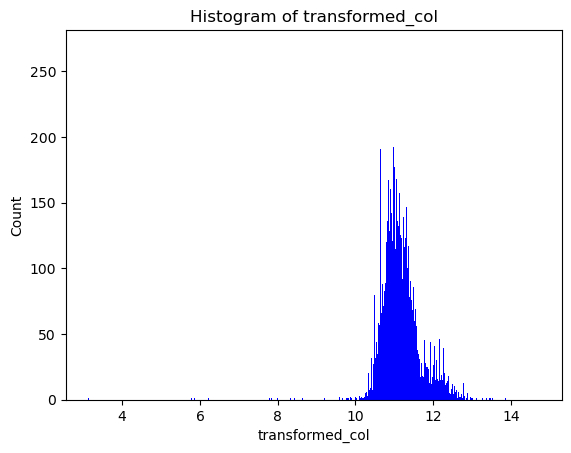

In [49]:
# select the column you want to plot
column_to_plot = 'transformed_col'

# create the histogram using matplotlib
plt.hist(df17[column_to_plot], bins=1000, color='blue')

# add x-axis and y-axis labels
plt.xlabel(column_to_plot)
plt.ylabel('Count')

# add a title to the plot
plt.title('Histogram of ' + column_to_plot)

# show the plot
plt.show()

#### Mean-STD Method

In [50]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.transformed_col)
        st = np.std(subdf.transformed_col)
        reduced_df = subdf[(subdf.transformed_col>(m-st)) & (subdf.transformed_col<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df18 = remove_pps_outliers(df17)
df18.shape

(8896, 27)

#### Median-MAD Method

In [51]:
def remove_pps_outliers_mad(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = df['price_per_sqft'].median()
        mad = sp.stats.median_abs_deviation(df['price_per_sqft'])
        reduced_df = subdf[(subdf.price_per_sqft>(m-mad)) & (subdf.price_per_sqft<=(m+mad))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df18b = remove_pps_outliers_mad(df17)
df18b.shape

(6424, 27)

#### We will stick with a softer approach (Mean-STD)

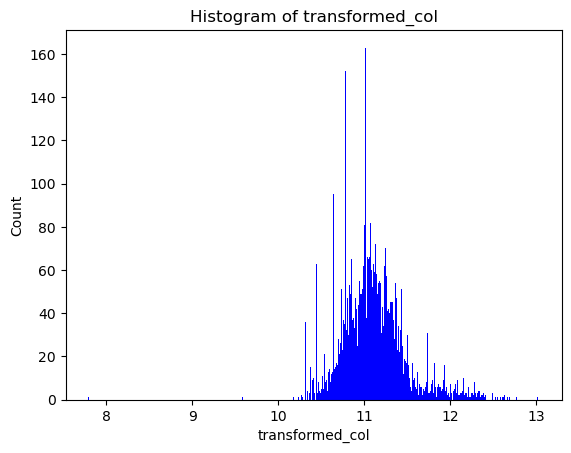

In [52]:
# select the column you want to plot
column_to_plot = 'transformed_col'

# create the histogram using matplotlib
plt.hist(df18[column_to_plot], bins=1000, color='blue')

# add x-axis and y-axis labels
plt.xlabel(column_to_plot)
plt.ylabel('Count')

# add a title to the plot
plt.title('Histogram of ' + column_to_plot)

# show the plot
plt.show()

In [53]:
df19 = df18.drop(columns=['transformed_col', 'transformed_col1'])

<AxesSubplot:>

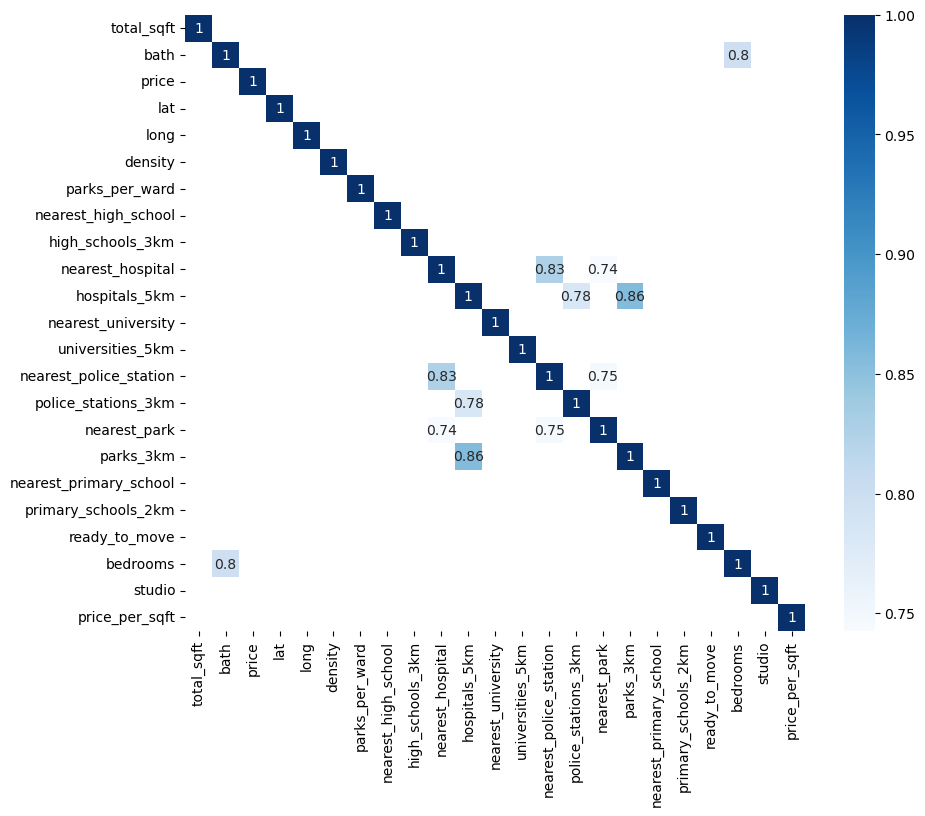

In [54]:
corr = df19.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr,mask = corr<0.7 ,annot= True,cmap = 'Blues')

#### Removing records with a location that appears in less than 10 records (Prone to false results)

In [55]:
location_stats = df19['location'].value_counts(ascending=False)
location_stats

Whitefield              388
Sarjapur  Road          280
Kanakpura Road          240
Electronic City         199
Yelahanka               179
                       ... 
Dasappa Layout            1
Phase 1 Kammasandra       1
Postal Colony             1
Crimson Layout            1
1st Block BEL Layout      1
Name: location, Length: 773, dtype: int64

In [56]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Giri Nagar              10
Bommenahalli            10
Yelenahalli             10
Yelachenahalli          10
Dasarahalli             10
                        ..
Dasappa Layout           1
Phase 1 Kammasandra      1
Postal Colony            1
Crimson Layout           1
1st Block BEL Layout     1
Name: location, Length: 595, dtype: int64

In [57]:
df20 = df19.copy()

df20.location = df20.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

df20 = df20[df20.location != 'other']
df20 = df20.reset_index(drop=True)
df20['location'].unique()

array(['1st Phase JP Nagar', '2nd Stage Nagarbhavi', '5th Phase JP Nagar',
       '6th Phase JP Nagar', '7th Phase JP Nagar', '8th Phase JP Nagar',
       '9th Phase JP Nagar', 'Abbigere', 'Akshaya Nagar', 'Ambalipura',
       'Ambedkar Nagar', 'Amruthahalli', 'Anandapura', 'Ananth Nagar',
       'Anekal', 'Ardendale', 'Attibele', 'BEML Layout', 'BTM 2nd Stage',
       'BTM Layout', 'Babusapalaya', 'Balagere', 'Banashankari',
       'Banashankari Stage II', 'Banashankari Stage III',
       'Banashankari Stage V', 'Banaswadi', 'Bannerghatta',
       'Bannerghatta Road', 'Basavangudi', 'Battarahalli', 'Begur',
       'Begur Road', 'Bellandur', 'Benson Town', 'Bhoganhalli',
       'Billekahalli', 'Binny Pete', 'Bisuvanahalli', 'Bommanahalli',
       'Bommasandra', 'Bommasandra Industrial Area', 'Brookefield',
       'Budigere', 'CV Raman Nagar', 'Chandapura', 'Channasandra',
       'Chikka Tirupathi', 'Chikkalasandra', 'Choodasandra',
       'Cunningham Road', 'Devanahalli', 'Devarachikka

#### The number of bathrooms and bedrooms is highly correlated. We can use that for outlier removal

In [58]:
df21 = df20.copy()
df21 = df21[df21.bath<df21.bedrooms+2]
df21.shape

(6972, 25)

### One-hot encoding
#### Creating dummies for 'location'

In [59]:
dummies = pd.get_dummies(df21.location)
dummies.head(3)

,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,...,Uttarahalli,Varthur,Vasanthapura,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df22 = df21.copy()

df22 = pd.concat([df22,dummies],axis='columns')

## removing 'location' as we have already created the dummies
df22 = df22.drop('location',axis = 1)

#### Creating dummies for 'ward'

In [61]:
dummies1 = pd.get_dummies(df22.ward)
dummies1.head(3)

,A. Narayanapura,Anjanapura,Arakere,Aramanenagar,Attur,BTM Layout,Banaswadi,Basavanagudi,Basavanapura,Begur,...,Singasandra,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vasanthnagar,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df23 = df22.copy()

df23 = pd.concat([df23,dummies1],axis='columns')

## removing 'location' as we have already created the dummies
df23 = df23.drop('ward',axis = 1)

df23.head()

,total_sqft,bath,price,lat,long,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,...,Singasandra,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vasanthnagar,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,2825,4,250.0,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,...,0,0,0,0,0,0,0,0,0,0
1,1875,3,167.0,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,...,0,0,0,0,0,0,0,0,0,0
2,2065,4,210.0,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,...,0,0,0,0,0,0,0,0,0,0
3,2024,3,157.0,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,...,0,0,0,0,0,0,0,0,0,0
4,2059,3,225.0,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,...,0,0,0,0,0,0,0,0,0,0


#### Drop the supplementary column 'price_per_sqft' used for outliers removal

In [63]:
df24 = df23.drop('price_per_sqft',axis = 1)

### Build the model

In [64]:
X = df24.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,lat,long,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,...,Singasandra,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vasanthnagar,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,2825,4,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,197,...,0,0,0,0,0,0,0,0,0,0
1,1875,3,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,197,...,0,0,0,0,0,0,0,0,0,0
2,2065,4,12.911837,77.579495,13946,9.0,0.242898,19,0.093771,197,...,0,0,0,0,0,0,0,0,0,0


In [65]:
X.shape

(6972, 278)

In [66]:
y = df24.price
y.head(3)

0    250.0
1    167.0
2    210.0
Name: price, dtype: float64

In [67]:
len(y)

6972

### Feature Selection
#### We create our custom scorer and run SFS
Remove the comments if you want to run feature selection. Keep in mind that the parallel version (16 cores) takes ~22 hours

In [68]:
# create a Random Forest Classifier object with default values
#rfs = RandomForestRegressor()

def rmsle(y_true, y_pred):
     return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
    
scorer = make_scorer(rmsle, greater_is_better=True)

# run sequential forward selection
# sfs_range = SFS(rfs, k_features='best', forward=True, floating=False, verbose=2, scoring=scorer, cv=5, n_jobs=16)

# # train the sequential forward selection object
# sfs_range = sfs_range.fit(X,y)

# # print the accuracy of the best combination as well as the set of best features
# print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))

# plt.rcParams["figure.figsize"] = (6,6)
# # use the plot_sfs to visualize all accuracies
# plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

#### We are selecting the best columns based on the results of SFS. We do it manually to avoid running SFS in each run of the jupyter notebook. 
Uncomment the first line if you want to run SFS and select automatically the best rows

In [69]:
#X_sfs = X.iloc[:, list(sfs_range.k_feature_idx_)]
X_sfs = X.iloc[:, [0, 1, 2, 3, 7, 9, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 61, 63, 64, 65, 68, 70, 72, 73, 74, 75, 78, 79, 81, 83, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 100, 102, 103, 105, 106, 107, 109, 111, 112, 113, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 131, 136, 137, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 190, 193, 194, 195, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 224, 226, 227, 228, 229, 232, 233, 234, 235, 236, 239, 240, 241, 242, 243, 244, 246, 248, 249, 250, 251, 253, 255, 256, 257, 260, 262, 264, 265, 266, 269, 270, 271, 272, 274, 275, 276, 277]]
X_sfs

,total_sqft,bath,lat,long,high_schools_3km,hospitals_5km,nearest_police_station,police_stations_3km,ready_to_move,bedrooms,...,Sarakki,Shakambarinagar,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,2825,4,12.911837,77.579495,19,197,0.869022,8,1,4,...,0,1,0,0,0,0,0,0,0,0
1,1875,3,12.911837,77.579495,19,197,0.869022,8,1,3,...,0,1,0,0,0,0,0,0,0,0
2,2065,4,12.911837,77.579495,19,197,0.869022,8,1,3,...,0,1,0,0,0,0,0,0,0,0
3,2024,3,12.911837,77.579495,19,197,0.869022,8,1,3,...,0,1,0,0,0,0,0,0,0,0
4,2059,3,12.911837,77.579495,19,197,0.869022,8,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7025,1676,3,13.025030,77.534024,13,77,0.000000,6,1,3,...,0,0,0,0,0,0,0,0,0,0
7026,2503,3,13.025030,77.534024,13,77,0.000000,6,1,3,...,0,0,0,0,0,0,0,0,0,0
7027,1855,3,13.025030,77.534024,13,77,0.000000,6,1,3,...,0,0,0,0,0,0,0,0,0,0
7028,1876,3,13.025030,77.534024,13,77,0.000000,6,1,3,...,0,0,0,0,0,0,0,0,0,0


In [70]:
pd.set_option('display.max_rows', 1000) # display up to 1000 rows
X_sfs.dtypes

total_sqft                     int64
bath                           int32
lat                          float64
long                         float64
high_schools_3km               int32
hospitals_5km                  int32
nearest_police_station       float64
police_stations_3km            int32
ready_to_move                  int64
bedrooms                       int32
studio                         int64
1st Phase JP Nagar             uint8
2nd Stage Nagarbhavi           uint8
5th Phase JP Nagar             uint8
6th Phase JP Nagar             uint8
7th Phase JP Nagar             uint8
8th Phase JP Nagar             uint8
9th Phase JP Nagar             uint8
Abbigere                       uint8
Ambalipura                     uint8
Ambedkar Nagar                 uint8
Amruthahalli                   uint8
Anandapura                     uint8
Ananth Nagar                   uint8
Anekal                         uint8
BEML Layout                    uint8
BTM 2nd Stage                  uint8
B

In [71]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(RandomForestRegressor(), X_sfs, y, cv=cv)

array([0.9218138 , 0.91367538, 0.90021845, 0.90656594, 0.91484272])

In [72]:
X_sfs.describe()

,total_sqft,bath,lat,long,high_schools_3km,hospitals_5km,nearest_police_station,police_stations_3km,ready_to_move,bedrooms,...,Sarakki,Shakambarinagar,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
count,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,...,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000
mean,1449.567126,2.385542,12.947500,77.637832,8.789443,57.688612,1.838093,2.955536,0.760757,2.516495,...,0.007602,0.002582,0.040448,0.006885,0.020511,0.029260,0.002725,0.003155,0.003012,0.001865
std,659.135249,0.820906,0.083292,0.075568,5.277182,51.273965,2.178988,3.435831,0.426652,0.751711,...,0.086863,0.050749,0.197020,0.082694,0.141749,0.168546,0.052136,0.056089,0.054803,0.043144
min,300.000000,0.000000,12.709058,77.459445,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1110.000000,2.000000,12.890984,77.584508,4.000000,18.000000,0.622560,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1280.000000,2.000000,12.935193,77.643148,9.000000,48.000000,1.305272,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1630.000000,3.000000,13.013906,77.694364,12.000000,72.000000,1.973203,4.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11890.000000,6.000000,13.229278,77.866742,27.000000,239.000000,15.156187,28.000000,1.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### GridSearchCV
#### We tested all the regressor algorithms to see which works best for our dataset
REMOVED ALL THE REGRESSORS THAT PRODUCE NEGATIVE VALUES - THIS IS THE REASON WE GOT 0% ON OUR MACHINE HACK SUBMISSION
The metric RMSLE can't deal with negative values

In [73]:
regressors = [
    {'name': 'AdaBoostRegressor', 'reg': AdaBoostRegressor(), 'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}},
    {'name': 'BaggingRegressor', 'reg': BaggingRegressor(), 'params': {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0], 'bootstrap': [True, False]}},
    {'name': 'DecisionTreeRegressor', 'reg': DecisionTreeRegressor(), 'params': {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'ExtraTreeRegressor', 'reg': ExtraTreeRegressor(), 'params': {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'ExtraTreesRegressor', 'reg': ExtraTreesRegressor(), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'GradientBoostingRegressor', 'reg': GradientBoostingRegressor(), 'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'HistGradientBoostingRegressor', 'reg': HistGradientBoostingRegressor(), 'params': {'max_iter': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2, 4], 'l2_regularization': [0, 0.1, 1]}},
    {'name': 'KNeighborsRegressor', 'reg': KNeighborsRegressor(), 'params': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}},
    {'name': 'LassoLars', 'reg': LassoLars(), 'params': {'alpha': [0.1, 1, 10]}},
    {'name': 'PoissonRegressor', 'reg': PoissonRegressor(), 'params': {'alpha': [0.1, 1, 10]}},
    {'name': 'RandomForestRegressor', 'reg': RandomForestRegressor(), 'params': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}},
    {'name': 'StackingRegressor', 'reg': StackingRegressor(estimators= [('knn', KNeighborsRegressor())], final_estimator=LinearRegression()), 'params': {}},
    {'name': 'VotingRegressor', 'reg': VotingRegressor([("lr", LinearRegression()), ("knn", KNeighborsRegressor()), ("rf", RandomForestRegressor())]), 'params': {}},
]


In [74]:
def find_best_model_using_gridsearchcv(XX,y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for config in regressors:
        gs =  GridSearchCV(config['reg'], config['params'], cv=cv, return_train_score=False, verbose=3, scoring=scorer)
        gs.fit(XX,y)
        scores.append({
            'model': config['name'],
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

scores = []
best_regr = find_best_model_using_gridsearchcv(X_sfs,y)
best_regr

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.683 total time=   1.8s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.700 total time=   1.8s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=0.683 total time=   1.6s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.692 total time=   1.6s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=0.695 total time=   1.6s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.682 total time=   3.5s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.700 total time=   3.3s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.683 total time=   3.7s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.691 total time=   4.0s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.695 total time=   3.3s
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=0.684 total time=   6.8s
[CV 2/5] END learning_rate=0.01,

[CV 5/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=50;, score=0.839 total time=   1.5s
[CV 1/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=100;, score=0.845 total time=   3.0s
[CV 2/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=100;, score=0.843 total time=   3.2s
[CV 3/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=100;, score=0.831 total time=   3.2s
[CV 4/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=100;, score=0.846 total time=   3.5s
[CV 5/5] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=100;, score=0.842 total time=   3.1s
[CV 1/5] END bootstrap=True, max_features=1.0, max_samples=1.0, n_estimators=10;, score=0.839 total time=   0.4s
[CV 2/5] END bootstrap=True, max_features=1.0, max_samples=1.0, n_estimators=10;, score=0.833 total time=   0.3s
[CV 3/5] END bootstrap=True, max_features=1.0, max_samples=1.0, n_estimators=10;, score=0.8

[CV 2/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=50;, score=0.799 total time=   2.9s
[CV 3/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=50;, score=0.799 total time=   2.9s
[CV 4/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=50;, score=0.812 total time=   3.1s
[CV 5/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=50;, score=0.809 total time=   3.1s
[CV 1/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=100;, score=0.810 total time=   5.9s
[CV 2/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=100;, score=0.799 total time=   6.3s
[CV 3/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=100;, score=0.799 total time=   6.7s
[CV 4/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=100;, score=0.812 total time=   6.2s
[CV 5/5] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=100;, 

[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2;, score=0.738 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2;, score=0.741 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2;, score=0.740 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2;, score=0.740 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2;, score=0.742 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=5;, score=0.738 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=5;, score=0.741 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=5;, score=0.740 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=5;, score=0.740 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=5;, score=0.741 total time=   0.0s
[CV 1/5] E

[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.799 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.800 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10;, score=0.799 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10;, score=0.798 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10;, score=0.792 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10;, score=0.806 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10;, score=0.790 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=4, min_samples_split=2;, score=0.799 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=2;, score=0.801 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=4, min_samples_split=2;, score=

[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2;, score=0.757 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2;, score=0.754 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=0.774 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=0.769 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=0.776 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=0.773 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=0.754 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=10;, score=0.771 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=10;, score=0.752 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=10;, score=0.730 total time=   0.

[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.839 total time=   0.3s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.828 total time=   0.4s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.844 total time=   0.4s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.837 total time=   0.3s
[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.844 total time=   2.0s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.842 total time=   2.0s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.834 total time=   1.9s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.847 total time=   2.0s
[CV 5/5] END max_depth=None, min_samples_leaf=2,

[CV 1/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.838 total time=   4.9s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.837 total time=   3.9s
[CV 3/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.828 total time=   3.8s
[CV 4/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.842 total time=   4.1s
[CV 5/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.836 total time=   4.0s
[CV 1/5] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.835 total time=   0.3s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.834 total time=   0.3s
[CV 3/5] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.825 total time=   0.3s
[CV 4/5] END max_depth=None, min_samples

[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.713 total time=   0.7s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.721 total time=   0.6s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.715 total time=   0.6s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.720 total time=   0.8s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.729 total time=   0.7s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.713 total time=   1.8s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.720 total time=   1.4s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.714 total time=   1.3s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_

[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.715 total time=   0.1s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.694 total time=   0.1s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.727 total time=   0.1s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=10;, score=0.726 total time=   0.1s
[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.714 total time=   0.6s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.714 total time=   0.6s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.721 total time=   0.6s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.722 total time=   0.6s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=

[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.794 total time=   3.5s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.788 total time=   4.3s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.796 total time=   3.2s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.793 total time=   4.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.785 total time=   0.3s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.787 total time=   0.3s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.784 total time=   0.3s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.799 total time=   0.2s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_s

[CV 2/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.790 total time=   1.2s
[CV 3/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.788 total time=   1.2s
[CV 4/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.798 total time=   1.0s
[CV 5/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.793 total time=   1.0s
[CV 1/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.791 total time=   2.6s
[CV 2/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.792 total time=   2.4s
[CV 3/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.788 total time=   2.3s
[CV 4/5] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.799 total time=   2.4s
[CV 5/5] END max_depth=10, min_samples_leaf=4, min_s

[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.641 total time=   1.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.639 total time=   1.3s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.645 total time=   1.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.708 total time=   2.5s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.715 total time=   2.4s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.711 total time=   2.4s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.714 total time=   2.4s
[CV 5/5] END learning_rate=0.01, max_dept

[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.641 total time=   2.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.639 total time=   1.5s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.645 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.707 total time=   2.7s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.715 total time=   2.7s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.711 total time=   2.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.714 total time=   2.6s
[CV 5/5] END learning_rate=0.01, max_dept

[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.676 total time=   2.2s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.674 total time=   2.1s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.682 total time=   2.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.758 total time=   4.3s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.757 total time=   4.3s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.758 total time=   4.1s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.763 total time=   3.9s
[CV 5/5] END learning_rate=0.01, m

[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.677 total time=   2.1s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.674 total time=   1.9s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.682 total time=   2.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.758 total time=   4.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.757 total time=   5.2s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.759 total time=   5.5s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.763 total time=   5.9s
[CV 5/5] END learning_rate=0.01, max_dept

[CV 3/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.704 total time=   3.3s
[CV 4/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.704 total time=   3.3s
[CV 5/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.711 total time=   3.4s
[CV 1/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.803 total time=   6.7s
[CV 2/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.798 total time=   7.0s
[CV 3/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.795 total time=   6.9s
[CV 4/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.803 total time=   7.1s
[CV 5/5] END learning_rate=0.01, m

[CV 3/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.706 total time=   3.2s
[CV 4/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.705 total time=   3.4s
[CV 5/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.711 total time=   3.6s
[CV 1/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.803 total time=   7.0s
[CV 2/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.800 total time=   6.6s
[CV 3/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.796 total time=   6.8s
[CV 4/5] END learning_rate=0.01, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.805 total time=   6.8s
[CV 5/5] END learning_rate=

[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.804 total time=   1.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.815 total time=   1.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.814 total time=   1.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.821 total time=   2.3s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.823 total time=   2.3s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.821 total time=   2.3s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.826 total time=   2.3s
[CV 5/5] END learning_rate=0.1, max_depth=3, min

[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.814 total time=   1.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.814 total time=   1.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.820 total time=   2.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.823 total time=   2.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.821 total time=   2.3s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.827 total time=   2.3s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.826 total time=   2.3s
[CV 1/5] END learning_rate=0.1, max_depth=3, min

[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.814 total time=   1.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.822 total time=   2.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.824 total time=   2.3s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.821 total time=   2.3s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.827 total time=   2.3s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.828 total time=   2.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.818 total time=   0.9s
[CV 2/5] END learning_rate=0.1, max_depth=5

[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.839 total time=   3.9s
[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.840 total time=   3.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.836 total time=   3.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.846 total time=   3.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.840 total time=   3.7s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.819 total time=   0.9s
[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.815 total time=   0.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_s

[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.840 total time=   3.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.836 total time=   3.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.846 total time=   3.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.841 total time=   3.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.815 total time=   0.9s
[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.812 total time=   0.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.814 total time=   0.9s
[CV 4/5] END learning_rate=0.1, max_depth=5, min

[CV 2/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.848 total time=   7.4s
[CV 3/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.838 total time=   7.2s
[CV 4/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.854 total time=   7.1s
[CV 5/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.847 total time=   7.1s
[CV 1/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.843 total time=   1.8s
[CV 2/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.842 total time=   1.7s
[CV 3/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.833 total time=   1.8s
[CV 4/5] END learning_rate=0.1, max_dept

[CV 2/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.850 total time=   7.3s
[CV 3/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.838 total time=   8.2s
[CV 4/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.852 total time=   7.6s
[CV 5/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.842 total time=   7.4s
[CV 1/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.839 total time=   2.1s
[CV 2/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.843 total time=   2.2s
[CV 3/5] END learning_rate=0.1, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.833 total time=   1.7s
[CV 4/5] END learning_rate=0.1, max_depth=10

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.788 total time=   0.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.818 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   1.1s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.810 total time=   1.1s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.825 total time=   1.1s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.786 total time=   1.1s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.817 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   2.8s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.812 total time=   3.0s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.825 total time=   2.8s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.781 total time=   2.8s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.805 total time=   0.5s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.812 total time=   0.7s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.808 total time=   0.6s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=nan total time=   1.1s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.819 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=nan total time=   2.3s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.816 total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.831 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=nan total time=   2.3s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.804 total time=   0.5s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.810 total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=nan total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.822 total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=nan total time=   0.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.819 total time=   1.1s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.824 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   1.1s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.833 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   1.1s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.825 total time=   2.3s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.827 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=nan total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.834 total time=   2.3s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.827 total time=   2.3s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.823 total time=   0.5s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.812 total time=   0.5s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.814 total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.809 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, mi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=nan total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.808 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.814 total time=   0.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.830 total time=   1.1s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.823 total time=   1.1s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.813 total time=   1.1s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.816 total time=   1.1s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=nan total time=   0.5s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.815 total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.804 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.826 total time=   0.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.828 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=nan total time=   1.1s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.821 total time=   1.1s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.823 total time=   1.1s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.833 total time=   1.1s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.828 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=   2.3s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.824 total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.828 total time=   2.3s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.824 total time=   2.3s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.802 total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=nan total time=   0.5s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.810 total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.811 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.816 total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   1.5s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.812 total time=   1.2s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.837 total time=   1.4s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.820 total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.840 total time=   2.8s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.821 total time=   2.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.801 total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=nan total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=nan total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.811 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.816 total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.1s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.837 total time=   1.1s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.820 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   2.6s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.840 total time=   2.3s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.821 total time=   2.5s
[CV 1/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.810 total time=   0.5s
[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.800 total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.813 total time=   0.5s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.816 total time=   0.5s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   2.3s
[CV 3/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.825 total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.836 total time=   2.3s
[CV 5/5] END learning_rate=1, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.821 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.8s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.820 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.829 total time=   0.9s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.817 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.817 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.813 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   3.6s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.797 total time=   3.6s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.817 total time=   0.9s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.818 total time=   0.8s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.816 total time=   0.9s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.823 total time=   0.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.821 total time=   0.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_sa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=nan total time=   5.0s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.819 total time=   4.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.824 total time=   1.1s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.821 total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.808 total time=   0.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.835 total time=   1.0s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.816 total time=   1.1s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   1.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.821 total time=   1.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.814 total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.818 total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=nan total time=   3.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=nan total time=   3.6s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.817 total time=   3.7s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.804 total time=   3.7s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.819 total time=   0.8s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.811 total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.822 total time=   0.9s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.827 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=nan total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.820 total time=   1.8s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.812 total time=   1.8s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.820 total time=   1.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.825 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.816 total time=   3.6s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.805 total time=   3.7s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.812 total time=   3.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.817 total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.816 total time=   0.9s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.818 total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=nan total time=   0.9s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.822 total time=   0.9s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.798 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.813 total time=   1.8s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.810 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.810 total time=   3.7s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.800 total time=   3.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=nan total time=   3.6s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.811 total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=nan total time=   3.7s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.817 total time=   0.9s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.824 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=nan total time=   0.8s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.836 total time=   0.9s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.798 total time=   0.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.813 total time=   2.3s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.822 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=nan total time=   2.3s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.834 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=nan total time=   2.3s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.808 total time=   4.3s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.819 total time=   4.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=   3.7s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.830 total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=   3.6s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.829 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=nan total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=nan total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=nan total time=   0.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.823 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.825 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   1.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.823 total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.823 total time=   3.7s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.817 total time=   3.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   3.7s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.815 total time=   3.7s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.829 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=nan total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=nan total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=nan total time=   0.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.823 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.825 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   1.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.823 total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.823 total time=   3.7s
[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.817 total time=   3.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   3.6s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.815 total time=   3.7s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.813 total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=nan total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.815 total time=   0.9s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.824 total time=   0.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.820 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.817 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   1.8s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.815 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   1.8s
[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.825 total time=   1.8s
[CV 1/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.818 total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   3.6s
[CV 3/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.810 total time=   4.7s
[CV 4/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.812 total time=   4.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   4.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   1.9s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.769 total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   1.8s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.806 total time=   1.6s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.801 total time=   1.6s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.799 total time=   3.3s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.786 total time=   3.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   3.3s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.805 total time=   3.3s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.797 total time=   3.3s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.806 total time=   6.8s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.797 total time=   6.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   6.9s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.801 total time=   6.7s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.801 total time=   6.7s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.800 total time=   1.6s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.795 total time=   1.6s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.785 total time=   1.7s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.792 total time=   1.6s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   3.4s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.812 total time=   3.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=nan total time=   3.3s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.799 total time=   6.8s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.795 total time=   6.9s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.777 total time=   6.9s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.811 total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=nan total time=   6.8s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.809 total time=   1.6s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.796 total time=   1.7s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.789 total time=   1.7s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.812 total time=   1.7s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.798 total time=   1.6s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.795 total time=   3.4s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=nan total time=   1.6s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.812 total time=   1.6s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.796 total time=   1.7s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.803 total time=   3.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   3.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   3.4s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.807 total time=   3.4s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.791 total time=   3.4s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.802 total time=   6.9s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.799 total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=nan total time=   6.9s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.806 total time=   6.8s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.792 total time=   7.0s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.806 total time=   1.6s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.777 total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=nan total time=   1.7s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.812 total time=   1.6s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.808 total time=   1.7s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.804 total time=   3.4s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.784 total time=   3.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=nan total time=   3.4s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.805 total time=   3.4s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.800 total time=   3.4s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.797 total time=  16.3s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.785 total time=  18.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=  16.7s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.801 total time=  15.9s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.796 total time=  16.4s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.812 total time=   3.9s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.806 total time=   3.9s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.798 total time=   4.1s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.813 total time=   4.0s
[CV 5/5] END learning_rate=1, max_depth=10, min_samples_le

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=nan total time=   3.9s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.800 total time=   8.0s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.804 total time=   7.8s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.792 total time=   7.9s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.813 total time=   7.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   7.8s
[CV 1/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.800 total time=  16.2s
[CV 2/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.798 total time=  15.9s
[CV 3/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.789 total time=  16.5s
[CV 4/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.811 total time=  18.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END learning_rate=1, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=  16.4s
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.580 total time=   5.4s
[CV 2/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.582 total time=   5.3s
[CV 3/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.590 total time=   5.3s
[CV 4/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.585 total time=   5.2s
[CV 5/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.592 total time=   5.2s
[CV 1/5] END l2_regularization=0, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.581 total time=

[CV 1/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.669 total time=   5.6s
[CV 2/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.672 total time=   5.6s
[CV 3/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.675 total time=   5.6s
[CV 4/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.673 total time=   5.5s
[CV 5/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.682 total time=   5.5s
[CV 1/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.669 total time=   5.5s
[CV 2/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.672 total time=   5.5s
[CV 3/5] END l2_regularization=0, learning_rate=0.01, max_depth=5, ma

[CV 3/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.759 total time=  20.4s
[CV 4/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.763 total time=  16.8s
[CV 5/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.768 total time=  11.6s
[CV 1/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.757 total time=  11.6s
[CV 2/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.758 total time=  11.3s
[CV 3/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.759 total time=  11.4s
[CV 4/5] END l2_regularization=0, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.764 total time=  11.5s
[CV 5/5] END l2_regularization=0, learning_rate=0.01, max_dept

[CV 4/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.823 total time=   1.5s
[CV 5/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.816 total time=   1.5s
[CV 1/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.814 total time=   1.4s
[CV 2/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.814 total time=   1.4s
[CV 3/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.812 total time=   1.4s
[CV 4/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.824 total time=   1.4s
[CV 5/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.818 total time=   1.4s
[CV 1/5] END l2_regularization=0, learning_rate=0.1, max_depth=5, max_iter=50, min_

[CV 2/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.844 total time=   5.5s
[CV 3/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.838 total time=   5.5s
[CV 4/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.847 total time=   5.5s
[CV 5/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.842 total time=   5.4s
[CV 1/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.843 total time=   5.1s
[CV 2/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.843 total time=   5.1s
[CV 3/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.838 total time=   5.1s
[CV 4/5] END l2_regularization=0, learning_rate=0.1, max_depth=10, ma

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=nan total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=nan total time=   3.0s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.792 total time=   3.1s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.825 total time=   3.1s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.812 total time=   3.0s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.805 total time=   2.9s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.818 total time=   2.9s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.812 total time=   2.9s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=nan total time=   6.0s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.781 total time=   5.9s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.781 total time=   6.2s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.818 total time=   5.9s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.806 total time=   6.0s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.799 total time=   5.8s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.806 total time=   5.7s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.7s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=0.798 total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=nan total time=  11.9s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.776 total time=  12.0s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.776 total time=  11.7s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.814 total time=  11.6s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.802 total time=  11.7s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.792 total time=  11.1s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.798 total time=  11.4s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=nan total time=  10.7s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.808 total time=  10.8s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.799 total time=  11.1s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.824 total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=nan total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=nan total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=nan total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=nan total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=nan total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=nan total time=   1.3s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.807 total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=nan total time=   1.3s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.821 total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=nan total time=   1.1s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.812 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=nan total time=   1.1s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.826 total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=nan total time=   1.1s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.818 total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=1;, score=nan total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=1;, score=nan total time=   3.0s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.808 total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=1;, score=nan total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=nan total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=nan total time=   2.7s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.801 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=nan total time=   2.8s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.820 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.3s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.791 total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.3s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.826 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.3s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.811 total time=   6.1s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.789 total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=nan total time=   6.0s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.794 total time=   6.0s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.806 total time=   5.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=nan total time=   5.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=nan total time=   5.3s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=0.802 total time=   5.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=nan total time=   5.3s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=0.820 total time=   5.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=nan total time=   4.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=nan total time=   4.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=nan total time=   4.3s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.826 total time=   4.5s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.813 total time=   4.5s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.788 total time=   2.6s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.807 total time=   2.7s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.800 total time=   2.8s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.823 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=nan total time=   2.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.7s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=0.815 total time=   2.6s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=0.800 total time=   2.6s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=0.819 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.7s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.811 total time=   2.5s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.818 total time=   2.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.5s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.824 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.4s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.786 total time=   5.2s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.803 total time=   5.2s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.796 total time=   5.2s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.815 total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=nan total time=   5.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.0s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.809 total time=   5.0s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.792 total time=   5.1s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.818 total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.2s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.808 total time=   4.6s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.812 total time=   4.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=nan total time=   4.6s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.817 total time=   4.7s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.807 total time=   4.7s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.784 total time=  10.5s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.798 total time=  11.0s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.793 total time=  11.0s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.810 total time=  10.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=nan total time=  10.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=  10.2s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.803 total time=   9.9s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.787 total time=   9.9s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.812 total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=   9.9s
[CV 1/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.804 total time=   9.5s
[CV 2/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.806 total time=   9.4s
[CV 3/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.790 total time=   9.7s
[CV 4/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.810 total time=  10.0s
[CV 5/5] END l2_regularization=0, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.806 total time=  10.0s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.580 total time=   3.0s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=None, max_ite

[CV 1/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.581 total time=   1.5s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.582 total time=   1.5s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.589 total time=   1.7s
[CV 4/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.584 total time=   1.6s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.590 total time=   1.6s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.669 total time=   3.4s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.672 total time=   3.4s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.01, max_

[CV 2/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.672 total time=   6.2s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.677 total time=   6.1s
[CV 4/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.675 total time=   6.2s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.682 total time=   6.0s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.756 total time=  12.2s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.758 total time=  12.3s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.759 total time=  12.4s
[CV 4/5] END l2_regularization=0.1, learning_rat

[CV 3/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.841 total time=  11.3s
[CV 4/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.854 total time=  10.8s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.847 total time=  10.5s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.816 total time=   1.4s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.815 total time=   1.5s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.812 total time=   1.5s
[CV 4/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.824 total time=   1.5s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.1, ma

[CV 5/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.831 total time=   2.8s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.842 total time=   5.2s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.842 total time=   5.6s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.836 total time=   5.5s
[CV 4/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.847 total time=   5.6s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.843 total time=   5.5s
[CV 1/5] END l2_regularization=0.1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.841 total time=   5.3s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.1, m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=nan total time=   2.8s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.821 total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=1;, score=nan total time=   3.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=nan total time=   3.1s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.818 total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.9s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.821 total time=   3.0s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.806 total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.7s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=0.820 total time=   2.8s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=0.815 total time=   2.8s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=0.832 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=nan total time=   3.0s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.796 total time=   6.1s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.806 total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=nan total time=   5.6s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.817 total time=   5.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=nan total time=   5.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.3s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.810 total time=   5.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.5s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.818 total time=   5.3s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.808 total time=   5.5s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=0.793 total time=   5.3s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=0.819 total time=   5.2s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=0.812 total time=   5.4s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=0.827 total time=   5.5s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=nan total time=  12.0s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.812 total time=  11.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=nan total time=  11.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=nan total time=  11.0s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.803 total time=  11.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=nan total time=  11.2s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.798 total time=  11.0s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.800 total time=  11.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=nan total time=  10.8s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.812 total time=  11.3s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.805 total time=  11.1s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.819 total time=  10.6s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=0.808 total time=  10.8s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.815 total time=   1.5s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.783 total time=   1.4s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=nan total time=   1.2s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.825 total time=   1.1s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.813 total time=   1.2s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.821 total time=   1.0s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.803 total time=   1.2s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.808 total time=   1.1s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=4;, score=0.834 total time=   1.2s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=50, min_sa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=nan total time=   2.8s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.819 total time=   2.4s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.811 total time=   2.5s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.819 total time=   2.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.1s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.808 total time=   2.1s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.836 total time=   2.2s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.816 total time=   2.4s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.802 total time=   5.9s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.785 total time=   5.9s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.806 total time=   6.7s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=nan total time=   5.3s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=0.809 total time=   5.0s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=2;, score=0.807 total time=   5.2s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.814 total time=   4.3s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.758 total time=   4.3s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.809 total time=   4.4s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.832 total time=   4.4s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=5, max_iter=200

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=nan total time=   2.7s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.823 total time=   2.7s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.813 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.6s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=0.798 total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.6s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=0.817 total time=   2.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=2;, score=nan total time=   2.5s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.819 total time=   2.4s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.793 total time=   2.4s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.802 total time=   2.4s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=0.821 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.4s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.808 total time=   5.2s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.778 total time=   5.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=nan total time=   5.6s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.822 total time=   5.7s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=1;, score=0.808 total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.8s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.797 total time=   6.1s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.783 total time=   5.7s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.810 total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=nan total time=   5.3s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.823 total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.3s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.799 total time=   5.1s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.816 total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.2s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.806 total time=  11.6s
[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.775 total time=  10.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=nan total time=  10.7s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.820 total time=  11.0s
[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.804 total time=  11.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=  10.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=  10.5s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.777 total time=  10.6s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.802 total time=  10.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=  10.4s
[CV 1/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.816 total time=   9.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=nan total time=   9.7s
[CV 3/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.794 total time=   9.5s
[CV 4/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.809 total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=0.1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=nan total time=   9.6s
[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.583 total time=   2.9s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.583 total time=   2.9s
[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.591 total time=   2.9s
[CV 4/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.587 total time=   2.9s
[CV 5/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=1;, score=0.593 total time=   3.2s
[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=50, min_samples_leaf=2;, score=0.583 total time=   3.0s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_d

[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.668 total time=   3.3s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.671 total time=   3.4s
[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.674 total time=   3.2s
[CV 4/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.673 total time=   3.2s
[CV 5/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=1;, score=0.680 total time=   3.3s
[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.668 total time=   3.3s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=100, min_samples_leaf=2;, score=0.671 total time=   3.3s
[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_depth=5, ma

[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.760 total time=  13.1s
[CV 4/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.766 total time=  12.2s
[CV 5/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1;, score=0.770 total time=  12.4s
[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.759 total time=  12.3s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.761 total time=  12.1s
[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.760 total time=  12.5s
[CV 4/5] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.767 total time=  12.7s
[CV 5/5] END l2_regularization=1, learning_rate=0.01, max_dept

[CV 4/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.824 total time=   1.5s
[CV 5/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.817 total time=   1.5s
[CV 1/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.814 total time=   1.4s
[CV 2/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.811 total time=   1.4s
[CV 3/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.808 total time=   1.5s
[CV 4/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.824 total time=   1.5s
[CV 5/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.818 total time=   1.4s
[CV 1/5] END l2_regularization=1, learning_rate=0.1, max_depth=5, max_iter=50, min_

[CV 2/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.842 total time=   5.1s
[CV 3/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.838 total time=   5.1s
[CV 4/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.847 total time=   5.1s
[CV 5/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=2;, score=0.842 total time=   5.3s
[CV 1/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.841 total time=   5.1s
[CV 2/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.843 total time=   5.0s
[CV 3/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, max_iter=100, min_samples_leaf=4;, score=0.837 total time=   5.2s
[CV 4/5] END l2_regularization=1, learning_rate=0.1, max_depth=10, ma

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=50, min_samples_leaf=4;, score=nan total time=   2.8s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.818 total time=   5.8s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.821 total time=   6.1s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.810 total time=   6.1s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.817 total time=   6.0s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=1;, score=0.826 total time=   5.8s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=2;, score=0.820 total time=   5.6s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=100, min_samples_leaf=4;, score=nan total time=   5.8s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.815 total time=  12.3s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.808 total time=  11.8s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.807 total time=  11.4s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.812 total time=  12.0s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=1;, score=0.824 total time=  11.6s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=2;, score=0.818 total time=  11.1s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=nan total time=  10.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=None, max_iter=200, min_samples_leaf=4;, score=nan total time=  10.8s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.816 total time=   1.3s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.815 total time=   1.4s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.816 total time=   1.5s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.834 total time=   1.6s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=1;, score=0.829 total time=   1.5s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2;, score=0.820 total time=   1.4s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=50, min_samples_leaf=2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.4s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.820 total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=nan total time=   2.3s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=100, min_samples_leaf=4;, score=0.825 total time=   2.3s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.814 total time=   5.9s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.808 total time=   5.9s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.812 total time=   5.8s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.824 total time=   5.8s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=1;, score=0.820 total time=   5.9s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_le

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=nan total time=   4.5s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.820 total time=   4.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=nan total time=   4.5s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=5, max_iter=200, min_samples_leaf=4;, score=0.823 total time=   4.5s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.808 total time=   2.6s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.822 total time=   2.8s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.813 total time=   2.8s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.832 total time=   2.7s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_leaf=1;, score=0.823 total time=   2.8s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=50, min_samples_le

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\lambr\AppData\Local\Temp\ipykernel_22524\2328077497.py", line 5, in rmsle
    return 1 - np.sqrt(mean_squared_log_error(y_true, y_pred))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
Value

[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=nan total time=  10.2s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.801 total time=  10.1s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.810 total time=  10.1s
[CV 5/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=2;, score=0.818 total time=  10.2s
[CV 1/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.815 total time=   9.5s
[CV 2/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.812 total time=   9.5s
[CV 3/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_samples_leaf=4;, score=0.805 total time=   9.6s
[CV 4/5] END l2_regularization=1, learning_rate=1, max_depth=10, max_iter=200, min_sa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.58581253 0.5860431  0.58658381 0.67338008 0.6739439  0.67508172
 0.76074    0.76117809 0.7622586  0.58569484 0.58549181 0.58553323
 0.67455496 0.67445502 0.67447747 0.75983607 0.76008618 0.75992892
 0.58581253 0.5860431  0.58658381 0.67338008 0.6739439  0.67508172
 0.76053383 0.76106157 0.76225974 0.83118889 0.83127342 0.83124464
 0.84212551 0.84309738 0.84352869 0.84623804 0.8475318  0.84803456
 0.81662682 0.816318   0.81638218 0.83095445 0.83103837 0.83058128
 0.83991588 0.83974581 0.83997948 0.8304961  0.83075731 0.83055896
 0.84200121 0.8423336  0.84295214 0.84631965 0.84686493 0.84778716
        nan 0.81169821        nan        nan 0.79605734        nan
        nan 0.79161919        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        n

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.776 total time=   0.1s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.783 total time=   0.1s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.766 total time=   0.1s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.774 total time=   0.1s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.778 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.784 total time=   0.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.788 total time=   0.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.776 total time=   0.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.787 total time=   0.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.788 total time=   0.1s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.775 total time=   0.1s
[CV 2/5] END ....n_neighbors=5, weights=uniform;,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproc

[CV 1/5] END .........................alpha=0.1;, score=0.718 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.721 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.714 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.725 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.721 total time=   0.0s
[CV 1/5] END ...........................alpha=1;, score=0.420 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproc

[CV 2/5] END ...........................alpha=1;, score=0.413 total time=   0.0s
[CV 3/5] END ...........................alpha=1;, score=0.415 total time=   0.0s
[CV 4/5] END ...........................alpha=1;, score=0.418 total time=   0.0s
[CV 5/5] END ...........................alpha=1;, score=0.412 total time=   0.0s
[CV 1/5] END ..........................alpha=10;, score=0.420 total time=   0.0s
[CV 2/5] END ..........................alpha=10;, score=0.413 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproc

[CV 3/5] END ..........................alpha=10;, score=0.415 total time=   0.0s
[CV 4/5] END ..........................alpha=10;, score=0.418 total time=   0.0s
[CV 5/5] END ..........................alpha=10;, score=0.412 total time=   0.0s
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:323: RuntimeWarning: invalid value encountered in add
  d

[CV 1/5] END .........................alpha=0.1;, score=0.420 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.413 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.415 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  re

[CV 4/5] END .........................alpha=0.1;, score=0.418 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.412 total time=   0.0s
[CV 1/5] END ...........................alpha=1;, score=0.420 total time=   0.0s
[CV 2/5] END ...........................alpha=1;, score=0.413 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  re

[CV 3/5] END ...........................alpha=1;, score=0.415 total time=   0.0s
[CV 4/5] END ...........................alpha=1;, score=0.418 total time=   0.0s
[CV 5/5] END ...........................alpha=1;, score=0.412 total time=   0.0s
[CV 1/5] END ..........................alpha=10;, score=0.420 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  re

[CV 2/5] END ..........................alpha=10;, score=0.413 total time=   0.0s
[CV 3/5] END ..........................alpha=10;, score=0.415 total time=   0.0s
[CV 4/5] END ..........................alpha=10;, score=0.418 total time=   0.0s
[CV 5/5] END ..........................alpha=10;, score=0.412 total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=auto, n_estimators=50;, score=0.846 total time=   2.4s
[CV 2/5] END max_features=auto, n_estimators=50;, score=0.841 total time=   2.0s
[CV 3/5] END max_features=auto, n_estimators=50;, score=0.832 total time=   1.9s
[CV 4/5] END max_features=auto, n_estimators=50;, score=0.846 total time=   1.9s
[CV 5/5] END max_features=auto, n_estimators=50;, score=0.841 total time=   1.8s
[CV 1/5] END max_features=auto, n_estimators=100;, score=0.846 total time=   3.7s
[CV 2/5] END max_features=auto, n_estimators=100;, score=0.841 total time=   4.1s
[CV 3/5] END max_features=auto, n_estimators=100;, score=0.832 total time=   4.0s
[CV 4/5] END max_features=auto, n_estimators=100;, score=0.849 total time=   3.9s
[CV 5/5] END max_features=auto, n_estimators=100;, score=0.841 total time=   4.2s
[CV 1/5] END max_features=auto, n_estimators=200;, score=0.847 total time=   7.8s
[CV 2/5] END max_features=auto, n_estimator

,model,best_score,best_params
0,AdaBoostRegressor,0.692052,"{'learning_rate': 0.01, 'n_estimators': 200}"
1,BaggingRegressor,0.842190,"{'bootstrap': True, 'max_features': 1.0, 'max_..."
2,DecisionTreeRegressor,0.816792,"{'max_depth': None, 'min_samples_leaf': 4, 'mi..."
3,ExtraTreeRegressor,0.802335,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
4,ExtraTreesRegressor,0.842655,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
5,GradientBoostingRegressor,0.847073,"{'learning_rate': 0.1, 'max_depth': 10, 'min_s..."
6,HistGradientBoostingRegressor,0.848328,"{'l2_regularization': 1, 'learning_rate': 0.1,..."
7,KNeighborsRegressor,0.793683,"{'n_neighbors': 10, 'weights': 'distance'}"
8,LassoLars,0.719723,{'alpha': 0.1}
9,PoissonRegressor,0.415559,{'alpha': 0.1}


In [175]:
pd.set_option('display.max_colwidth', None)
best_regr

,model,best_score,best_params
0,AdaBoostRegressor,0.692052,"{'learning_rate': 0.01, 'n_estimators': 200}"
1,BaggingRegressor,0.842190,"{'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}"
2,DecisionTreeRegressor,0.816792,"{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}"
3,ExtraTreeRegressor,0.802335,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}"
4,ExtraTreesRegressor,0.842655,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}"
5,GradientBoostingRegressor,0.847073,"{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}"
6,HistGradientBoostingRegressor,0.848328,"{'l2_regularization': 1, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'min_samples_leaf': 4}"
7,KNeighborsRegressor,0.793683,"{'n_neighbors': 10, 'weights': 'distance'}"
8,LassoLars,0.719723,{'alpha': 0.1}
9,PoissonRegressor,0.415559,{'alpha': 0.1}


#### We train the best algorithms and some of the best algorithms too (the difference is pretty small)

In [173]:
algorithm_name = best_row['model']
parameters = best_row['best_params']
algorithm = eval(algorithm_name)(**parameters)
algorithm.fit(X_sfs, y)

HistGradientBoostingRegressor(l2_regularization=1, max_iter=200,
                              min_samples_leaf=4)

In [176]:
bagging_regr = BaggingRegressor(bootstrap=True, max_features=1.0, max_samples=1.0, n_estimators=100)
extra_trees_regr = ExtraTreesRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100)
grad_boost_regr = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200)
hist_grad_boost_regr = HistGradientBoostingRegressor(l2_regularization=1, learning_rate=0.1, max_depth=None, max_iter=200, min_samples_leaf=4)
random_forest_regr = RandomForestRegressor(max_features='auto', n_estimators=200)

In [177]:
bagging_regr.fit(X_sfs, y)

BaggingRegressor(n_estimators=100)

In [178]:
extra_trees_regr.fit(X_sfs, y)

ExtraTreesRegressor(min_samples_split=10)

In [179]:
grad_boost_regr.fit(X_sfs, y)

GradientBoostingRegressor(max_depth=10, min_samples_split=10, n_estimators=200)

In [180]:
hist_grad_boost_regr.fit(X_sfs, y)

HistGradientBoostingRegressor(l2_regularization=1, max_iter=200,
                              min_samples_leaf=4)

In [181]:
random_forest_regr.fit(X_sfs, y)

RandomForestRegressor(n_estimators=200)

### Getting our test dataset ready
#### We apply almost the same sequence of actions as above. However, we never delete any records. Instead we fill them with the mean value when it's possible

In [82]:
ts1 = pd.read_csv('Test.csv')

ts1

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,NaN
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,NaN
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,NaN
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,NaN


In [83]:
#Trim unecessary spaces in the beginning of the column
ts1['location'] = ts1['location'].str.lstrip()
ts1.drop(columns=['price'],inplace = True)

ts1

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0
...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0


In [84]:
ts2 = ts1.copy()

ts2['location'] = ts2['location'].fillna('missing')

ts2

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0
...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0


In [85]:
# merge the two dataframes on the 'location' column
ts3 = pd.merge(ts2, locations, on='location', how='left')
ts3[ts3['ward'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward
326,Plot Area,Ready To Move,nynappanahalli,3 Bedroom,NaN,3600,3.0,1.0,NaN,NaN,NaN
454,Super built-up Area,18-Mar,Rajarajeshwari Nagar,3 BHK,NaN,1410,2.0,2.0,NaN,NaN,NaN
489,Super built-up Area,Ready To Move,Shanthinagar,2 BHK,NaN,1080,2.0,2.0,NaN,NaN,NaN
1163,Super built-up Area,Ready To Move,near ullas theater,4 BHK,NaN,2600,3.0,3.0,NaN,NaN,NaN
1257,Super built-up Area,Ready To Move,#NAME?,3 BHK,NaN,1600,2.0,1.0,NaN,NaN,NaN


In [86]:
ts2.loc[ts2['location'] == 'Rajarajeshwari Nagar','location'] = 'Rajarajeshwari Nagara'
ts2.loc[ts2['location'] == 'Shanthinagar', 'location'] = 'Shanti Nagar'
ts2.loc[ts2['location'] == 'near ullas theater', 'location'] = 'Near ullas theater'
ts2.loc[ts2['location'] == 'nynappanahalli', 'location'] = 'BTM 4th Stage'
ts2.loc[ts2['location'] == '#NAME?', 'location'] = 'missing'

ts3 = pd.merge(ts2, locations, on='location', how='left')

ts3[ts3['ward'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward
1257,Super built-up Area,Ready To Move,missing,3 BHK,NaN,1600,2.0,1.0,NaN,NaN,NaN


In [87]:
ts3b = pd.merge(ts3, ward_density, on='ward', how='left')
ts3b

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,Doddanekkundi,5270.0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,Begur,4216.0
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,HBR Layout,12717.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,Bilekahalli,11721.0
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,Anjanapura,3997.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,Outside of town,27566.0
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,Gottigere,7049.0
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,Hagadooru,4003.0
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,Outside of town,27566.0


In [134]:
ts3c = pd.merge(ts3b, ward_parks, on='ward', how='left')
ts3c

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density,parks_per_ward
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,Doddanekkundi,5270.0,7.0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,Begur,4216.0,0.0
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,HBR Layout,12717.0,5.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,Bilekahalli,11721.0,5.0
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,Anjanapura,3997.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,Outside of town,27566.0,NaN
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,Gottigere,7049.0,2.0
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,Hagadooru,4003.0,1.0
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,Outside of town,27566.0,NaN


In [135]:
ts3c['ward'] = ts3c['ward'].fillna('missing')
ts3c['lat'] = ts3c['lat'].fillna(ts3c['lat'].mean())
ts3c['long'] = ts3c['long'].fillna(ts3c['long'].mean())
ts3c['parks_per_ward'] = ts3c['parks_per_ward'].fillna(ts3c['parks_per_ward'].mean())
ts3c['density'] = ts3c['density'].fillna(ts3c['density'].mean())

ts3c[ts3c['long'].isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density,parks_per_ward


In [136]:
ts4 = find_nearest_places(ts3c, high_schools, "high_schools_3km", "nearest_high_school", 3)

ts4

#df4[df4["high_schools_3km"].isna()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,Doddanekkundi,5270.0,7.000000,1.051436,9
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,Begur,4216.0,0.000000,2.144852,4
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,HBR Layout,12717.0,5.000000,1.220832,12
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,Bilekahalli,11721.0,5.000000,1.243176,9
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,Anjanapura,3997.0,5.000000,0.289757,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,Outside of town,27566.0,4.122466,1.569574,2
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,Gottigere,7049.0,2.000000,0.217266,4
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,Hagadooru,4003.0,1.000000,1.069071,6
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,Outside of town,27566.0,4.122466,1.865235,1


In [137]:
ts5 = find_nearest_places(ts4, hospitals, "hospitals_5km", "nearest_hospital", 5)

ts5

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,Doddanekkundi,5270.0,7.000000,1.051436,9,0.235652,53
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,Begur,4216.0,0.000000,2.144852,4,1.271498,41
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,HBR Layout,12717.0,5.000000,1.220832,12,0.954018,118
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,Bilekahalli,11721.0,5.000000,1.243176,9,0.621746,157
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,Anjanapura,3997.0,5.000000,0.289757,15,0.527077,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,Outside of town,27566.0,4.122466,1.569574,2,1.772065,26
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,Gottigere,7049.0,2.000000,0.217266,4,1.511123,26
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,Hagadooru,4003.0,1.000000,1.069071,6,1.120029,24
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,Outside of town,27566.0,4.122466,1.865235,1,4.195692,3


In [138]:
ts6 = find_nearest_places(ts5, universities, "universities_5km", "nearest_university", 5)

ts6

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,Doddanekkundi,5270.0,7.000000,1.051436,9,0.235652,53,8.950588,0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,Begur,4216.0,0.000000,2.144852,4,1.271498,41,2.747318,2
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,HBR Layout,12717.0,5.000000,1.220832,12,0.954018,118,3.939355,1
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,Bilekahalli,11721.0,5.000000,1.243176,9,0.621746,157,3.049196,4
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,Anjanapura,3997.0,5.000000,0.289757,15,0.527077,83,4.879432,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,Outside of town,27566.0,4.122466,1.569574,2,1.772065,26,1.953872,2
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,Gottigere,7049.0,2.000000,0.217266,4,1.511123,26,5.981703,0
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,Hagadooru,4003.0,1.000000,1.069071,6,1.120029,24,13.478028,0
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,Outside of town,27566.0,4.122466,1.865235,1,4.195692,3,9.554815,0


In [139]:
ts7 = find_nearest_places(ts6, police_stations, "police_stations_3km", "nearest_police_station", 3)

ts7

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,...,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,...,5270.0,7.000000,1.051436,9,0.235652,53,8.950588,0,3.134721,0
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,...,4216.0,0.000000,2.144852,4,1.271498,41,2.747318,2,1.427325,2
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,...,12717.0,5.000000,1.220832,12,0.954018,118,3.939355,1,1.773094,5
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,...,11721.0,5.000000,1.243176,9,0.621746,157,3.049196,4,1.305272,5
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,...,3997.0,5.000000,0.289757,15,0.527077,83,4.879432,1,0.197445,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,...,27566.0,4.122466,1.569574,2,1.772065,26,1.953872,2,2.866206,1
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,...,7049.0,2.000000,0.217266,4,1.511123,26,5.981703,0,2.564197,1
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,...,4003.0,1.000000,1.069071,6,1.120029,24,13.478028,0,1.228699,2
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,...,27566.0,4.122466,1.865235,1,4.195692,3,9.554815,0,3.789765,0


In [140]:
ts7b = find_nearest_places(ts7, parks, "parks_3km", "nearest_park", 3)

ts7b

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,...,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,...,1.051436,9,0.235652,53,8.950588,0,3.134721,0,0.543893,10
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,...,2.144852,4,1.271498,41,2.747318,2,1.427325,2,0.975165,18
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,...,1.220832,12,0.954018,118,3.939355,1,1.773094,5,0.108980,43
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,...,1.243176,9,0.621746,157,3.049196,4,1.305272,5,0.330802,106
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,...,0.289757,15,0.527077,83,4.879432,1,0.197445,3,0.867344,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,...,1.569574,2,1.772065,26,1.953872,2,2.866206,1,2.484172,1
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,...,0.217266,4,1.511123,26,5.981703,0,2.564197,1,0.000000,6
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,...,1.069071,6,1.120029,24,13.478028,0,1.228699,2,1.241454,2
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,...,1.865235,1,4.195692,3,9.554815,0,3.789765,0,2.000183,2


In [141]:
ts7c = find_nearest_places(ts7b, primary_schools, "primary_schools_2km", "nearest_primary_school", 2)

ts7c

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,...,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,...,0.235652,53,8.950588,0,3.134721,0,0.543893,10,0.470666,9
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,...,1.271498,41,2.747318,2,1.427325,2,0.975165,18,0.947945,5
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,...,0.954018,118,3.939355,1,1.773094,5,0.108980,43,0.000000,37
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,...,0.621746,157,3.049196,4,1.305272,5,0.330802,106,0.000000,12
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,...,0.527077,83,4.879432,1,0.197445,3,0.867344,28,0.000000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,12.855352,77.636520,...,1.772065,26,1.953872,2,2.866206,1,2.484172,1,1.139354,7
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,12.856443,77.588845,...,1.511123,26,5.981703,0,2.564197,1,0.000000,6,0.000000,7
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,12.979699,77.761624,...,1.120029,24,13.478028,0,1.228699,2,1.241454,2,0.000000,14
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,13.058265,77.468550,...,4.195692,3,9.554815,0,3.789765,0,2.000183,2,0.657619,6


In [142]:
ts7c.to_csv('new_test_set2.csv')

In [143]:
ts8 = ts7c.reset_index(drop=True)

ts8.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,lat,long,...,nearest_hospital,hospitals_5km,nearest_university,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,12.965480,77.718464,...,0.235652,53,8.950588,0,3.134721,0,0.543893,10,0.470666,9
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,12.867799,77.616684,...,1.271498,41,2.747318,2,1.427325,2,0.975165,18,0.947945,5
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,13.013906,77.626650,...,0.954018,118,3.939355,1,1.773094,5,0.108980,43,0.000000,37
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,12.895345,77.615037,...,0.621746,157,3.049196,4,1.305272,5,0.330802,106,0.000000,12
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,12.882219,77.565968,...,0.527077,83,4.879432,1,0.197445,3,0.867344,28,0.000000,10


In [144]:
ts9 = ts8.copy()
ts9['ready_to_move'] = ts9['availability'].apply(lambda x: 1 if x == 'Ready To Move' else 0)

In [145]:
ts10 = ts9.copy()
ts10.drop(columns=['availability','area_type', 'society', 'balcony'],inplace = True)
ts10.dtypes

location                   object
size                       object
total_sqft                 object
bath                      float64
lat                       float64
long                      float64
ward                       object
density                   float64
parks_per_ward            float64
nearest_high_school       float64
high_schools_3km            int32
nearest_hospital          float64
hospitals_5km               int32
nearest_university        float64
universities_5km            int32
nearest_police_station    float64
police_stations_3km         int32
nearest_park              float64
parks_3km                   int32
nearest_primary_school    float64
primary_schools_2km         int32
ready_to_move               int64
dtype: object

In [146]:
ts10.isnull().sum()

location                  0
size                      2
total_sqft                0
bath                      7
lat                       0
long                      0
ward                      0
density                   0
parks_per_ward            0
nearest_high_school       0
high_schools_3km          0
nearest_hospital          0
hospitals_5km             0
nearest_university        0
universities_5km          0
nearest_police_station    0
police_stations_3km       0
nearest_park              0
parks_3km                 0
nearest_primary_school    0
primary_schools_2km       0
ready_to_move             0
dtype: int64

In [147]:
ts10['size']

0           2 BHK
1       9 Bedroom
2       4 Bedroom
3           3 BHK
4           2 BHK
          ...    
1475        2 BHK
1476        3 BHK
1477        2 BHK
1478        2 BHK
1479        2 BHK
Name: size, Length: 1480, dtype: object

#### Convert object type columns to numeric

In [148]:
ts11 = ts10.copy()
# extract the number of bedrooms from the 'size' column
ts11['bedrooms'] = ts11['size'].str.split().str[0]

# replace empty strings with NaN values
ts11['bedrooms'] = ts11['bedrooms'].replace('', pd.NA)

# drop rows with NaN values in the 'bedrooms' column
ts11['bedrooms'] = ts11['bedrooms'].astype(float)
ts11['bedrooms'] = ts11['bedrooms'].fillna(ts11['bedrooms'].notnull().mean())
ts11['bedrooms'] = ts11['bedrooms'].astype('int')


In [149]:
ts12 = ts11.copy()
ts12['bath'] = ts12['bath'].fillna(ts12['bath'].notnull().mean())
ts12['bath'] = ts12['bath'].astype('int')

In [150]:
ts12['size']

0           2 BHK
1       9 Bedroom
2       4 Bedroom
3           3 BHK
4           2 BHK
          ...    
1475        2 BHK
1476        3 BHK
1477        2 BHK
1478        2 BHK
1479        2 BHK
Name: size, Length: 1480, dtype: object

In [151]:
ts13 = ts12.copy()
ts13['studio'] = ts13['size'].apply(lambda x: 0 if pd.isna(x) or x.split()[1] == 'BHK' else 1)
ts13.drop(columns=['size'],inplace = True)

In [152]:
ts13[~ts13["total_sqft"].apply(is_float)].head(10)

,location,total_sqft,bath,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio
42,Sarjapur Road,1691 - 2170,3,12.910933,77.684154,Bellandur,3041.0,1.000000,0.994897,10,...,0,1.967393,1,1.514300,2,0.000000,8,1,3,0
151,Chikkaballapur,1200 - 2000,0,13.435498,77.731534,Outside of town,27566.0,4.122466,22.522747,0,...,0,21.367405,0,25.237682,0,7.074786,0,0,0,0
174,Yelahanka,1892 - 2798,3,13.115466,77.606998,Kempegowda Ward,3182.0,0.000000,0.000000,10,...,0,0.000000,1,0.000000,14,0.000000,99,0,3,0
180,Whitefield,524 - 894,1,12.969820,77.749972,Hagadooru,4003.0,1.000000,0.714559,6,...,0,0.629064,2,0.293975,2,0.069651,15,0,1,0
215,HBR Layout,534 - 763,1,13.035324,77.628470,HBR Layout,12717.0,5.000000,0.499601,8,...,0,1.088208,3,0.000000,24,0.591125,16,0,1,0
260,Whitefield,1498 - 1523,3,12.969820,77.749972,Hagadooru,4003.0,1.000000,0.714559,6,...,0,0.629064,2,0.293975,2,0.069651,15,0,3,0
325,Doddaballapur,5Acres,1,13.295714,77.536391,Outside of town,27566.0,4.122466,2.525515,1,...,0,17.217723,0,1.176381,1,4.394392,0,0,1,1
351,Rachenahalli,660 - 690,1,13.061519,77.616380,Thanisandra,7161.0,1.000000,0.505800,9,...,1,2.006576,2,0.000000,19,0.498794,11,0,1,0
382,Old Madras Road,1165 - 1225,2,13.051515,77.758360,Outside of town,27566.0,4.122466,2.237596,1,...,0,5.685993,0,6.388555,0,0.000000,2,0,2,0
387,Binny Pete,2695 - 2940,0,12.967566,77.558359,Binnipete,48081.0,2.000000,1.269355,13,...,6,0.672573,28,0.760943,48,0.413497,47,0,4,0


In [153]:
ts14 = ts13.copy()
ts14['total_sqft'] = ts14['total_sqft'].apply(convert_to_sqft)
max_id = ts14['total_sqft'].idxmax()

print('ID of maximum value:', max_id)
print(ts14.loc[max_id])
print(ts13.loc[max_id])

ID of maximum value: 325
location                    Doddaballapur
total_sqft                         217800
bath                                    1
lat                             13.295714
long                            77.536391
ward                      Outside of town
density                           27566.0
parks_per_ward                   4.122466
nearest_high_school              2.525515
high_schools_3km                        1
nearest_hospital                 4.279988
hospitals_5km                           1
nearest_university              14.125354
universities_5km                        0
nearest_police_station          17.217723
police_stations_3km                     0
nearest_park                     1.176381
parks_3km                               1
nearest_primary_school           4.394392
primary_schools_2km                     0
ready_to_move                           0
bedrooms                                1
studio                                  1
Name: 325

In [154]:
ts14[~ts14["total_sqft"].apply(is_float)].head(10)

,location,total_sqft,bath,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio


In [155]:
ts14[ts14["total_sqft"].isnull()]

,location,total_sqft,bath,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,...,universities_5km,nearest_police_station,police_stations_3km,nearest_park,parks_3km,nearest_primary_school,primary_schools_2km,ready_to_move,bedrooms,studio


In [156]:
ts14["total_sqft"]

0       1225
1       2400
2       1650
3       1322
4       1161
        ... 
1475    1246
1476    1660
1477    1216
1478     996
1479    1150
Name: total_sqft, Length: 1480, dtype: int64

In [157]:
ts14.dtypes

location                   object
total_sqft                  int64
bath                        int32
lat                       float64
long                      float64
ward                       object
density                   float64
parks_per_ward            float64
nearest_high_school       float64
high_schools_3km            int32
nearest_hospital          float64
hospitals_5km               int32
nearest_university        float64
universities_5km            int32
nearest_police_station    float64
police_stations_3km         int32
nearest_park              float64
parks_3km                   int32
nearest_primary_school    float64
primary_schools_2km         int32
ready_to_move               int64
bedrooms                    int32
studio                      int64
dtype: object

In [158]:
categories = df21['location'].unique()

test_one_hot = pd.get_dummies(ts14['location'])

for category in categories:
    if category not in test_one_hot.columns:
        test_one_hot[category] = 0

# align the columns of the test set with the training set
test_one_hot = test_one_hot[dummies.columns]
test_one_hot = test_one_hot.astype('uint8')

In [159]:
ts15 = ts14.copy()

ts15 = pd.concat([ts15,test_one_hot],axis='columns')

## removing 'location' as we have already created the dummies
ts15 = ts15.drop('location',axis = 1)

ts15.head()

,total_sqft,bath,lat,long,ward,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,...,Uttarahalli,Varthur,Vasanthapura,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,1225,2,12.965480,77.718464,Doddanekkundi,5270.0,7.0,1.051436,9,0.235652,...,0,0,0,0,0,0,0,0,0,0
1,2400,9,12.867799,77.616684,Begur,4216.0,0.0,2.144852,4,1.271498,...,0,0,0,0,0,0,0,0,0,0
2,1650,5,13.013906,77.626650,HBR Layout,12717.0,5.0,1.220832,12,0.954018,...,0,0,0,0,0,0,0,0,0,0
3,1322,3,12.895345,77.615037,Bilekahalli,11721.0,5.0,1.243176,9,0.621746,...,0,0,0,0,0,0,0,0,0,0
4,1161,2,12.882219,77.565968,Anjanapura,3997.0,5.0,0.289757,15,0.527077,...,0,0,0,0,0,0,0,0,0,0


In [160]:
categories1 = df21['ward'].unique()

test_one_hot1 = pd.get_dummies(ts15['ward'])

for category in categories1:
    if category not in test_one_hot1.columns:
        test_one_hot1[category] = 0

# align the columns of the test set with the training set
test_one_hot1 = test_one_hot1[dummies1.columns]
test_one_hot1 = test_one_hot1.astype('uint8')


In [161]:
ts16 = ts15.copy()

ts16 = pd.concat([ts16,test_one_hot1],axis='columns')

## removing 'location' as we have already created the dummies
ts16 = ts16.drop('ward',axis = 1)

ts16.head()

,total_sqft,bath,lat,long,density,parks_per_ward,nearest_high_school,high_schools_3km,nearest_hospital,hospitals_5km,...,Singasandra,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vasanthnagar,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,1225,2,12.965480,77.718464,5270.0,7.0,1.051436,9,0.235652,53,...,0,0,0,0,0,0,0,0,0,0
1,2400,9,12.867799,77.616684,4216.0,0.0,2.144852,4,1.271498,41,...,0,0,0,0,0,0,0,0,0,0
2,1650,5,13.013906,77.626650,12717.0,5.0,1.220832,12,0.954018,118,...,0,0,0,0,0,0,0,0,0,0
3,1322,3,12.895345,77.615037,11721.0,5.0,1.243176,9,0.621746,157,...,0,0,0,0,0,0,0,0,0,0
4,1161,2,12.882219,77.565968,3997.0,5.0,0.289757,15,0.527077,83,...,0,0,0,0,0,0,0,0,0,0


In [162]:
X.dtypes

total_sqft                       int64
bath                             int32
lat                            float64
long                           float64
density                          int64
parks_per_ward                 float64
nearest_high_school            float64
high_schools_3km                 int32
nearest_hospital               float64
hospitals_5km                    int32
nearest_university             float64
universities_5km                 int32
nearest_police_station         float64
police_stations_3km              int32
nearest_park                   float64
parks_3km                        int32
nearest_primary_school         float64
primary_schools_2km              int32
ready_to_move                    int64
bedrooms                         int32
studio                           int64
1st Phase JP Nagar               uint8
2nd Stage Nagarbhavi             uint8
5th Phase JP Nagar               uint8
6th Phase JP Nagar               uint8
7th Phase JP Nagar       

In [163]:
ts16.dtypes

total_sqft                       int64
bath                             int32
lat                            float64
long                           float64
density                        float64
parks_per_ward                 float64
nearest_high_school            float64
high_schools_3km                 int32
nearest_hospital               float64
hospitals_5km                    int32
nearest_university             float64
universities_5km                 int32
nearest_police_station         float64
police_stations_3km              int32
nearest_park                   float64
parks_3km                        int32
nearest_primary_school         float64
primary_schools_2km              int32
ready_to_move                    int64
bedrooms                         int32
studio                           int64
1st Phase JP Nagar               uint8
2nd Stage Nagarbhavi             uint8
5th Phase JP Nagar               uint8
6th Phase JP Nagar               uint8
7th Phase JP Nagar       

#### Checking to see if our training dataset and test dataset after pro-processing have the same columns

In [164]:
if X.columns.equals(ts16.columns):
    print("The two dataframes have the same columns.")
else:
    print("The two dataframes do not have the same columns.")

The two dataframes have the same columns.


In [165]:
X_test_sfs = ts16.iloc[:, [0, 1, 2, 3, 7, 9, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 61, 63, 64, 65, 68, 70, 72, 73, 74, 75, 78, 79, 81, 83, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 100, 102, 103, 105, 106, 107, 109, 111, 112, 113, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 131, 136, 137, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 190, 193, 194, 195, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 224, 226, 227, 228, 229, 232, 233, 234, 235, 236, 239, 240, 241, 242, 243, 244, 246, 248, 249, 250, 251, 253, 255, 256, 257, 260, 262, 264, 265, 266, 269, 270, 271, 272, 274, 275, 276, 277]]
X_test_sfs

,total_sqft,bath,lat,long,high_schools_3km,hospitals_5km,nearest_police_station,police_stations_3km,ready_to_move,bedrooms,...,Sarakki,Shakambarinagar,Thanisandra,Uttarahalli,Varthur,Vasanthapura,Vidyapeetha,Vidyaranyapura,Vignananagar,Yelachenahalli
0,1225,2,12.965480,77.718464,9,53,3.134721,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,2400,9,12.867799,77.616684,4,41,1.427325,2,1,9,...,0,0,0,0,0,0,0,0,0,0
2,1650,5,13.013906,77.626650,12,118,1.773094,5,0,4,...,0,0,0,0,0,0,0,0,0,0
3,1322,3,12.895345,77.615037,9,157,1.305272,5,1,3,...,0,0,0,0,0,0,0,0,0,0
4,1161,2,12.882219,77.565968,15,83,0.197445,3,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,1246,2,12.855352,77.636520,2,26,2.866206,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1476,1660,3,12.856443,77.588845,4,26,2.564197,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1477,1216,2,12.979699,77.761624,6,24,1.228699,2,1,2,...,0,0,0,0,0,0,0,0,0,0
1478,996,2,13.058265,77.468550,1,3,3.789765,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [166]:
if X_sfs.columns.equals(X_test_sfs.columns):
    print("The two dataframes have the same columns.")
else:
    print("The two dataframes do not have the same columns.")

The two dataframes have the same columns.


In [167]:
X_test_sfs.isnull().sum()

total_sqft                   0
bath                         0
lat                          0
long                         0
high_schools_3km             0
hospitals_5km                0
nearest_police_station       0
police_stations_3km          0
ready_to_move                0
bedrooms                     0
studio                       0
1st Phase JP Nagar           0
2nd Stage Nagarbhavi         0
5th Phase JP Nagar           0
6th Phase JP Nagar           0
7th Phase JP Nagar           0
8th Phase JP Nagar           0
9th Phase JP Nagar           0
Abbigere                     0
Ambalipura                   0
Ambedkar Nagar               0
Amruthahalli                 0
Anandapura                   0
Ananth Nagar                 0
Anekal                       0
BEML Layout                  0
BTM 2nd Stage                0
BTM Layout                   0
Babusapalaya                 0
Balagere                     0
Banashankari                 0
Banashankari Stage V         0
Bannergh

### Predicting house prices

In [183]:
# predict the output of the X_test dataset
y_pred = algorithm.predict(X_test_sfs)
np.savetxt('best_algo.csv', y_pred, delimiter='\n')

In [185]:
y_pred1 = bagging_regr.predict(X_test_sfs)
np.savetxt('algo1.csv', y_pred1, delimiter='\n')
y_pred2 = extra_trees_regr.predict(X_test_sfs)
np.savetxt('algo2.csv', y_pred2, delimiter='\n')
y_pred3 = grad_boost_regr.predict(X_test_sfs)
np.savetxt('algo3.csv', y_pred3, delimiter='\n')
y_pred4 = hist_grad_boost_regr.predict(X_test_sfs)
np.savetxt('algo4.csv', y_pred4, delimiter='\n')
y_pred5 = random_forest_regr.predict(X_test_sfs)
np.savetxt('algo5.csv', y_pred5, delimiter='\n')